# **Medical Visual Question Answering (MedVQA) with CNN-LSTM, BLIP-2 and LLAVA**: ***Advnaced Machine Learning***

This project explores and implements three distinct deep learning and multimodal models: **CNN-LSTM**, **BLIP-2**, and **LLAVA**, for Medical Visual Question Answering using the SLAKE dataset. The goal is to develop high-performance, medically-relevant VQA systems.

## SLAKE Dataset Characteristics

This section provides an overview of the SLAKE (Synthetic Labeled Anatomy Knowledge-based Exploration) dataset, focusing on the characteristics of its English subset used in this project. The dataset statistics and distributions are derived from the `train.json` file.

### Summary Statistics

*   **Total English Samples**: 4919

### Distribution of Answer Types

The SLAKE dataset categorizes questions into 'OPEN' and 'CLOSED' types. A 'CLOSED' question typically has a definite, short answer (e.g., 'yes', 'no', 'CT'), while an 'OPEN' question requires a more descriptive or numerical response.

  - OPEN: 2976 (60.50%)
  - CLOSED: 1943 (39.50%)


### Distribution of Image Modalities

The medical images in the SLAKE dataset are sourced from various modalities, including CT (Computed Tomography), MRI (Magnetic Resonance Imaging), and X-Ray.

  - MRI: 1129 (22.95%)
  - CT: 2367 (48.12%)
  - X-RAY: 1423 (28.93%)


### Visualizations

The bar charts above illustrate the distributions detailed above:

*   **Distribution of Answer Types**: This chart shows the count of 'OPEN' and 'CLOSED' questions in the dataset, highlighting the prevalence of open-ended questions.
*   **Distribution of Image Modalities**: This chart displays the frequency of different imaging modalities (MRI, CT, X-Ray) present in the dataset, indicating the types of medical images the models are trained and evaluated on.


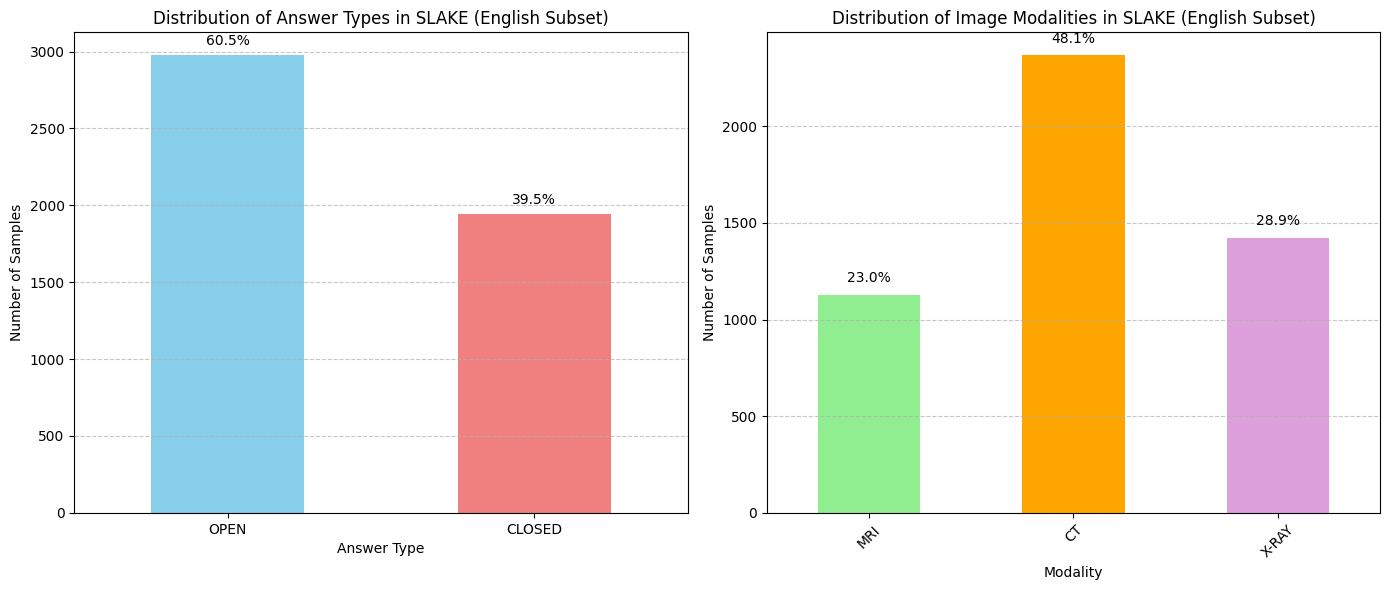

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming answer_type_df and modality_df are already defined from previous execution
# (They were defined in cell fd97b047 during the dataset analysis phase)

# Generate the plots
plt.figure(figsize=(14, 6))

# Plot 1: Answer Type Distribution
plt.subplot(1, 2, 1)
answer_type_df.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Distribution of Answer Types in SLAKE (English Subset)')
plt.xlabel('Answer Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentages to Answer Type bars
total_answer_types = answer_type_df.sum()
for i, count in enumerate(answer_type_df.values):
    percentage = f'{(count / total_answer_types) * 100:.1f}%'
    plt.text(i, count + (total_answer_types * 0.01), percentage, ha='center', va='bottom')


# Plot 2: Modality Distribution
plt.subplot(1, 2, 2)
modality_df.plot(kind='bar', color=['lightgreen', 'orange', 'plum'])
plt.title('Distribution of Image Modalities in SLAKE (English Subset)')
plt.xlabel('Modality')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentages to Modality bars
total_modalities = modality_df.sum()
for i, count in enumerate(modality_df.values):
    percentage = f'{(count / total_modalities) * 100:.1f}%'
    plt.text(i, count + (total_modalities * 0.01), percentage, ha='center', va='bottom')

plt.tight_layout()
plt.show()

## ***Experiment 1:***: Baseline CNN-LSTM Implementation

This script defines a traditional deep learning baseline for Medical Visual Question Answering using a fused **CNN-LSTM** architecture. It is designed for high-performance execution on 2026-era hardware through advanced PyTorch optimizations.

### 1. Architectural Design
The model (`MedVQA_CNNLSTM`) follows a dual-stream fusion approach:
*   **Visual Stream (CNN):** Uses a pre-trained **ResNet-50** backbone to extract spatial features from medical images, followed by a fully connected layer to project them into a shared embedding space.
*   **Textual Stream (LSTM):** Processes medical questions using an **Embedding layer** and a **Bidirectional LSTM** to capture the linguistic context from both directions.
*   **Fusion & Classifier:** Concatenates the visual and textual vectors, passing them through a multi-layer perceptron (MLP) with **Dropout (0.4)** to predict the final answer category.

### 2. Medical Image Preprocessing
*   **CLAHE (Contrast Limited Adaptive Histogram Equalization):** A specialized medical imaging technique implemented via OpenCV (`cv2`) to enhance the contrast of grayscale medical scans (X-rays, CTs) before they are fed into the CNN.
*   **Standardization:** Applies ImageNet-standard normalization and resizes all inputs to $224 \times 224$ pixels.

### 3. Data Pipeline & Vocabulary
*   **Dataset Class:** Handles the SLAKE English subset, performing on-the-fly tokenization and building a mapping for both words (`word_to_idx`) and answers (`ans_to_idx`).
*   **Padding:** Questions are standardized to a fixed length of 20 tokens to ensure uniform batch processing.

### 4. High-Performance Training Optimizations
The implementation utilizes several "State-of-the-Art" PyTorch utilities to maximize GPU utilization:
*   **Mixed Precision (AMP):** Uses `torch.amp.autocast` with `bfloat16` and a `GradScaler` to accelerate training while maintaining numerical stability.
*   **Memory Efficiency:** Implements `fused=True` in the **AdamW optimizer** and `non_blocking=True` for data transfers between CPU and GPU.
*   **Stability:** Employs **Gradient Clipping** and **Label Smoothing (0.1)** to prevent the model from becoming overconfident or suffering from exploding gradients.
*   **Scheduling:** Uses a **Cosine Annealing Learning Rate Scheduler** to fine-tune the model over 40 epochs.

### 5. Artifact Management
*   **Checkpointing:** Automatically monitors validation accuracy and saves the best-performing model state, including the vocabulary and class mappings, to `best_cnn_lstm.pth`.


In [ ]:
import os, json, torch, cv2, numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn


torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision('high')

class SlakeVQA_CNNLSTM_Dataset(Dataset):
    def __init__(self, drive_root, split_json, word_to_idx=None, ans_to_idx=None, is_train=True):
        self.drive_root = drive_root

        self.img_dir = os.path.join(drive_root, "imgs", "imgs")
        if not os.path.exists(self.img_dir):
            self.img_dir = os.path.join(drive_root, "imgs")

        json_path = os.path.join(drive_root, split_json)
        with open(json_path, 'r') as f:
            data = json.load(f)
        self.samples = [i for i in data if i.get("q_lang") == "en"]

        if is_train:
            self.word_to_idx = {"<PAD>": 0, "<UNK>": 1}
            self.ans_to_idx = {}
            for s in self.samples:
                for word in s['question'].lower().replace("?", "").split():
                    if word not in self.word_to_idx: self.word_to_idx[word] = len(self.word_to_idx)
                ans = str(s['answer']).lower().strip()
                if ans not in self.ans_to_idx: self.ans_to_idx[ans] = len(self.ans_to_idx)
        else:
            self.word_to_idx, self.ans_to_idx = word_to_idx, ans_to_idx

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def apply_clahe(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None: return Image.new('RGB', (224, 224))
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        return Image.fromarray(img).convert("RGB")

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        img_path = os.path.join(self.img_dir, s['img_name'])
        image = self.transform(self.apply_clahe(img_path))
        q_indices = [self.word_to_idx.get(w, 1) for w in s['question'].lower().split()]
        q_tensor = torch.zeros(20, dtype=torch.long)
        q_tensor[:min(len(q_indices), 20)] = torch.tensor(q_indices[:20])
        ans_label = self.ans_to_idx.get(str(s['answer']).lower().strip(), -1)
        return image, q_tensor, torch.tensor(ans_label)

class MedVQA_CNNLSTM(nn.Module):
    def __init__(self, vocab_size, num_classes, embed_dim=300, hidden_dim=512):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])
        self.v_fc = nn.Linear(resnet.fc.in_features, hidden_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.q_fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 1024), nn.ReLU(),
            nn.Dropout(0.4), # Increased dropout for regularization
            nn.Linear(1024, num_classes)
        )

    def forward(self, img, q):
        v_feat = self.cnn(img).view(img.size(0), -1)
        v_emb = torch.relu(self.v_fc(v_feat))
        q_emb = self.embedding(q)
        _, (h, _) = self.lstm(q_emb)
        q_feat = torch.cat((h[-2,:,:], h[-1,:,:]), dim=1)
        q_emb = torch.relu(self.q_fc(q_feat))
        return self.classifier(torch.cat((v_emb, q_emb), dim=1))

def run_training():
    DRIVE_ROOT = "/content/drive/MyDrive/LLaVA_Med_Slake_Thesis_2026/slake_dataset/"
    DEVICE = torch.device("cuda")

    train_ds = SlakeVQA_CNNLSTM_Dataset(DRIVE_ROOT, "train.json", is_train=True)
    val_ds = SlakeVQA_CNNLSTM_Dataset(DRIVE_ROOT, "validation.json", train_ds.word_to_idx, train_ds.ans_to_idx, is_train=False)

    train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

    model = MedVQA_CNNLSTM(len(train_ds.word_to_idx), len(train_ds.ans_to_idx)).to(DEVICE)

    # Lower LR and Higher Weight Decay for stability
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01, fused=True)
    # Cosine scheduler to help escape local minima
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)
    criterion = nn.CrossEntropyLoss(ignore_index=-1, label_smoothing=0.1)
    scaler = torch.amp.GradScaler('cuda')

    print(f"Vocab: {len(train_ds.word_to_idx)} | Classes: {len(train_ds.ans_to_idx)}")

    best_val_acc = 0.0

    for epoch in range(40):
        model.train()
        train_loss, train_acc = 0, 0
        for imgs, qs, labels in train_loader:
            imgs, qs, labels = imgs.to(DEVICE, non_blocking=True), qs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                preds = model(imgs, qs)
                loss = criterion(preds, labels)

            scaler.scale(loss).backward()

            #  Gradient Clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            train_acc += (preds.argmax(1) == labels).sum().item()

        scheduler.step()

        # Validation
        model.eval()
        val_acc = 0
        with torch.no_grad(), torch.amp.autocast('cuda', dtype=torch.bfloat16):
            for imgs, qs, labels in val_loader:
                imgs, qs, labels = imgs.to(DEVICE, non_blocking=True), qs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
                preds = model(imgs, qs)
                val_acc += (preds.argmax(1) == labels).sum().item()

        current_val_acc = val_acc / len(val_ds)
        print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc/len(train_ds):.4f} | Val Acc: {current_val_acc:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

        # Save Best Model
        if current_val_acc > best_val_acc:
            best_val_acc = current_val_acc
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'word_to_idx': train_ds.word_to_idx,
                'ans_to_idx': train_ds.ans_to_idx,
                'vocab_size': len(train_ds.word_to_idx),
                'num_classes': len(train_ds.ans_to_idx)
            }
            torch.save(checkpoint, "best_cnn_lstm.pth")

    return model, train_ds


model, train_ds = run_training()


Vocab: 305 | Classes: 221
Epoch 01 | Train Acc: 0.1559 | Val Acc: 0.1795 | LR: 0.000100
Epoch 02 | Train Acc: 0.1921 | Val Acc: 0.2526 | LR: 0.000099
Epoch 03 | Train Acc: 0.2954 | Val Acc: 0.3409 | LR: 0.000099
Epoch 04 | Train Acc: 0.4117 | Val Acc: 0.4558 | LR: 0.000098
Epoch 05 | Train Acc: 0.4781 | Val Acc: 0.5005 | LR: 0.000096
Epoch 06 | Train Acc: 0.5377 | Val Acc: 0.5223 | LR: 0.000095
Epoch 07 | Train Acc: 0.5792 | Val Acc: 0.5774 | LR: 0.000093
Epoch 08 | Train Acc: 0.6089 | Val Acc: 0.6163 | LR: 0.000090
Epoch 09 | Train Acc: 0.6396 | Val Acc: 0.6277 | LR: 0.000088
Epoch 10 | Train Acc: 0.6611 | Val Acc: 0.6439 | LR: 0.000085
Epoch 11 | Train Acc: 0.6873 | Val Acc: 0.6657 | LR: 0.000082
Epoch 12 | Train Acc: 0.7040 | Val Acc: 0.6610 | LR: 0.000079
Epoch 13 | Train Acc: 0.7160 | Val Acc: 0.6847 | LR: 0.000076
Epoch 14 | Train Acc: 0.7329 | Val Acc: 0.6933 | LR: 0.000073
Epoch 15 | Train Acc: 0.7455 | Val Acc: 0.6895 | LR: 0.000069
Epoch 16 | Train Acc: 0.7591 | Val Acc: 0.70

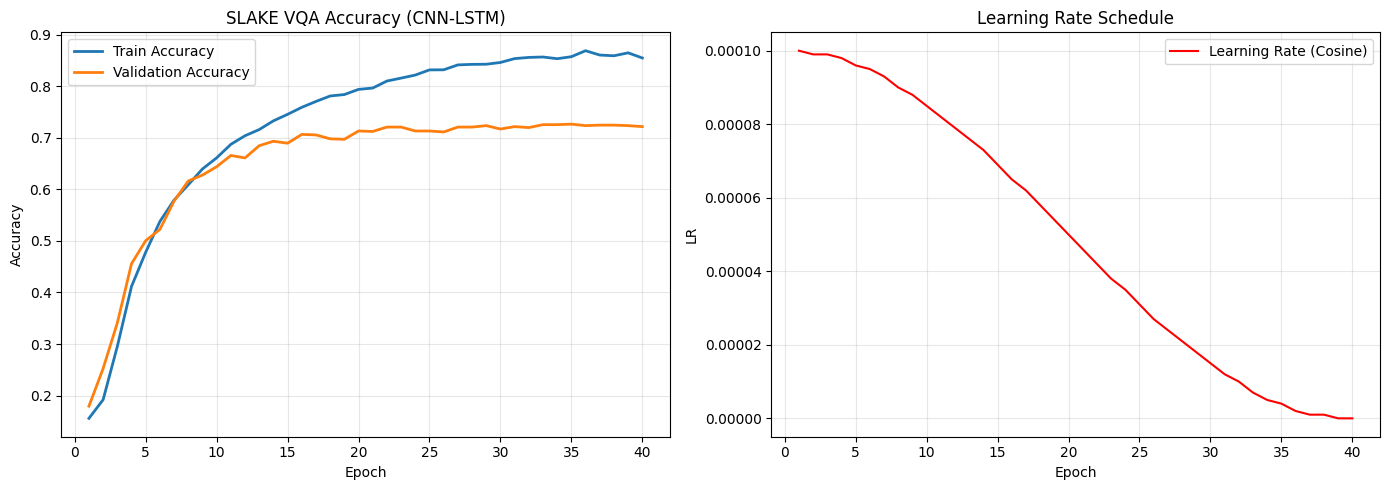

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import re

log_data = """Vocab: 305 | Classes: 221
Epoch 01 | Train Acc: 0.1559 | Val Acc: 0.1795 | LR: 0.000100
Epoch 02 | Train Acc: 0.1921 | Val Acc: 0.2526 | LR: 0.000099
Epoch 03 | Train Acc: 0.2954 | Val Acc: 0.3409 | LR: 0.000099
Epoch 04 | Train Acc: 0.4117 | Val Acc: 0.4558 | LR: 0.000098
Epoch 05 | Train Acc: 0.4781 | Val Acc: 0.5005 | LR: 0.000096
Epoch 06 | Train Acc: 0.5377 | Val Acc: 0.5223 | LR: 0.000095
Epoch 07 | Train Acc: 0.5792 | Val Acc: 0.5774 | LR: 0.000093
Epoch 08 | Train Acc: 0.6089 | Val Acc: 0.6163 | LR: 0.000090
Epoch 09 | Train Acc: 0.6396 | Val Acc: 0.6277 | LR: 0.000088
Epoch 10 | Train Acc: 0.6611 | Val Acc: 0.6439 | LR: 0.000085
Epoch 11 | Train Acc: 0.6873 | Val Acc: 0.6657 | LR: 0.000082
Epoch 12 | Train Acc: 0.7040 | Val Acc: 0.6610 | LR: 0.000079
Epoch 13 | Train Acc: 0.7160 | Val Acc: 0.6847 | LR: 0.000076
Epoch 14 | Train Acc: 0.7329 | Val Acc: 0.6933 | LR: 0.000073
Epoch 15 | Train Acc: 0.7455 | Val Acc: 0.6895 | LR: 0.000069
Epoch 16 | Train Acc: 0.7591 | Val Acc: 0.7066 | LR: 0.000065
Epoch 17 | Train Acc: 0.7705 | Val Acc: 0.7056 | LR: 0.000062
Epoch 18 | Train Acc: 0.7811 | Val Acc: 0.6980 | LR: 0.000058
Epoch 19 | Train Acc: 0.7839 | Val Acc: 0.6971 | LR: 0.000054
Epoch 20 | Train Acc: 0.7939 | Val Acc: 0.7132 | LR: 0.000050
Epoch 21 | Train Acc: 0.7965 | Val Acc: 0.7123 | LR: 0.000046
Epoch 22 | Train Acc: 0.8101 | Val Acc: 0.7208 | LR: 0.000042
Epoch 23 | Train Acc: 0.8158 | Val Acc: 0.7208 | LR: 0.000038
Epoch 24 | Train Acc: 0.8217 | Val Acc: 0.7132 | LR: 0.000035
Epoch 25 | Train Acc: 0.8317 | Val Acc: 0.7132 | LR: 0.000031
Epoch 26 | Train Acc: 0.8319 | Val Acc: 0.7113 | LR: 0.000027
Epoch 27 | Train Acc: 0.8414 | Val Acc: 0.7208 | LR: 0.000024
Epoch 28 | Train Acc: 0.8424 | Val Acc: 0.7208 | LR: 0.000021
Epoch 29 | Train Acc: 0.8427 | Val Acc: 0.7236 | LR: 0.000018
Epoch 30 | Train Acc: 0.8461 | Val Acc: 0.7170 | LR: 0.000015
Epoch 31 | Train Acc: 0.8536 | Val Acc: 0.7217 | LR: 0.000012
Epoch 32 | Train Acc: 0.8559 | Val Acc: 0.7198 | LR: 0.000010
Epoch 33 | Train Acc: 0.8567 | Val Acc: 0.7255 | LR: 0.000007
Epoch 34 | Train Acc: 0.8534 | Val Acc: 0.7255 | LR: 0.000005
Epoch 35 | Train Acc: 0.8573 | Val Acc: 0.7265 | LR: 0.000004
Epoch 36 | Train Acc: 0.8689 | Val Acc: 0.7236 | LR: 0.000002
Epoch 37 | Train Acc: 0.8605 | Val Acc: 0.7246 | LR: 0.000001
Epoch 38 | Train Acc: 0.8591 | Val Acc: 0.7246 | LR: 0.000001
Epoch 39 | Train Acc: 0.8648 | Val Acc: 0.7236 | LR: 0.000000
Epoch 40 | Train Acc: 0.8548 | Val Acc: 0.7217 | LR: 0.000000"""

epochs, train_accs, val_accs, lrs = [], [], [], []

for line in log_data.strip().split('\n'):
    # The fix: Escape the pipe \| and handle flexible spacing \s*
    match = re.search(r"Epoch\s*(\d+)\s*\|\s*Train Acc:\s*([\d.]+)\s*\|\s*Val Acc:\s*([\d.]+)\s*\|\s*LR:\s*([\d.]+)", line)
    if match:
        epochs.append(int(match.group(1)))
        train_accs.append(float(match.group(2)))
        val_accs.append(float(match.group(3)))
        lrs.append(float(match.group(4)))

df = pd.DataFrame({'Epoch': epochs, 'Train Acc': train_accs, 'Val Acc': val_accs, 'LR': lrs})

plt.figure(figsize=(14, 5))

# Plot 1: Accuracies
plt.subplot(1, 2, 1)
plt.plot(df['Epoch'], df['Train Acc'], label='Train Accuracy', lw=2)
plt.plot(df['Epoch'], df['Val Acc'], label='Validation Accuracy', lw=2)
plt.title('SLAKE VQA Accuracy (CNN-LSTM)')
plt.xlabel('Epoch'), plt.ylabel('Accuracy'), plt.legend(), plt.grid(True, alpha=0.3)

# Plot 2: Learning Rate
plt.subplot(1, 2, 2)
plt.plot(df['Epoch'], df['LR'], color='red', label='Learning Rate (Cosine)')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch'), plt.ylabel('LR'), plt.legend(), plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The plots above illustrate the training progress of the CNN-LSTM model:

*   **Training and Validation Accuracy**: This plot shows how the model's accuracy changes on both the training and validation datasets over each epoch. Ideally, both curves should increase, and the validation accuracy should not significantly diverge from the training accuracy, indicating good generalization and preventing overfitting.

*   **Learning Rate Schedule**: This plot visualizes the learning rate for each epoch. The cosine annealing schedule can be observed, where the learning rate starts at a higher value and gradually decreases, which helps in fine-tuning the model and escaping local minima.

In [ ]:
# Save only what is strictly necessary for testing
SAVE_PATH = "/content/drive/MyDrive/LLaVA_Med_Slake_Thesis_2026/cnn_lstm.pth"

checkpoint = {
    'model_state_dict': model.state_dict(),
    'word_to_idx': train_ds.word_to_idx,
    'ans_to_idx': train_ds.ans_to_idx,
    'vocab_size': len(train_ds.word_to_idx),
    'num_classes': len(train_ds.ans_to_idx)
}

torch.save(checkpoint, SAVE_PATH)
print(f"Model saved to: {SAVE_PATH}")


Model saved to: /content/drive/MyDrive/LLaVA_Med_Slake_Thesis_2026/cnn_lstm.pth


In [26]:
import os, json, torch, numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn
from collections import defaultdict, Counter
from tqdm.autonotebook import tqdm

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision('high')

class SlakeVQA_CNNLSTM_Dataset(Dataset):
    def __init__(self, drive_root, split_json, word_to_idx=None, ans_to_idx=None, is_train=True):
        self.drive_root = drive_root

        self.img_dir = os.path.join(drive_root, "imgs", "imgs")
        if not os.path.exists(self.img_dir):
            self.img_dir = os.path.join(drive_root, "imgs")

        json_path = os.path.join(drive_root, split_json)
        with open(json_path, 'r') as f:
            data = json.load(f)
        self.samples = [i for i in data if i.get("q_lang") == "en"]

        if is_train:
            self.word_to_idx = {"<PAD>": 0, "<UNK>": 1}
            self.ans_to_idx = {}
            for s in self.samples:
                for word in s['question'].lower().replace("?", "").split():
                    if word not in self.word_to_idx: self.word_to_idx[word] = len(self.word_to_idx)
                ans = str(s['answer']).lower().strip()
                if ans not in self.ans_to_idx: self.ans_to_idx[ans] = len(self.ans_to_idx)
        else:
            self.word_to_idx, self.ans_to_idx = word_to_idx, ans_to_idx

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def apply_clahe(self, img_path):
        import cv2 # Import cv2 here to ensure it's available in DataLoader worker processes
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None: return Image.new('RGB', (224, 224))
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        return Image.fromarray(img).convert("RGB")

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        img_path = os.path.join(self.img_dir, s['img_name'])
        image = self.transform(self.apply_clahe(img_path))
        q_indices = [self.word_to_idx.get(w, 1) for w in s['question'].lower().split()]
        q_tensor = torch.zeros(20, dtype=torch.long)
        q_tensor[:min(len(q_indices), 20)] = torch.tensor(q_indices[:20])
        ans_label = self.ans_to_idx.get(str(s['answer']).lower().strip(), -1)
        return image, q_tensor, torch.tensor(ans_label)

class MedVQA_CNNLSTM(nn.Module):
    def __init__(self, vocab_size, num_classes, embed_dim=300, hidden_dim=512):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])
        self.v_fc = nn.Linear(resnet.fc.in_features, hidden_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.q_fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 1024), nn.ReLU(),
            nn.Dropout(0.4), # Increased dropout for regularization
            nn.Linear(1024, num_classes)
        )

    def forward(self, img, q):
        v_feat = self.cnn(img).view(img.size(0), -1)
        v_emb = torch.relu(self.v_fc(v_feat))
        q_emb = self.embedding(q)
        _, (h, _) = self.lstm(q_emb)
        q_feat = torch.cat((h[-2,:,:], h[-1,:,:]), dim=1)
        q_emb = torch.relu(self.q_fc(q_feat))
        return self.classifier(torch.cat((v_emb, q_emb), dim=1))

def run_stratified_evaluation():
    # drive paths
    DRIVE_ROOT = "/content/drive/MyDrive/LLaVA_Med_Slake_Thesis_2026/slake_dataset/"
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    MODEL_PATH = "/content/drive/MyDrive/LLaVA_Med_Slake_Thesis_2026/cnn_lstm.pth"
    # MODEL_PATH='/content/best_cnn_lstm.pth'
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"Checkpoint not found at {MODEL_PATH}")

    # loading model
    print("Loading checkpoint metadata...")
    checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)

    #  initialize dataset with saved vocabulary to ensure test indices match training indices
    print("Initializing test dataset with saved vocabulary...")
    test_ds = SlakeVQA_CNNLSTM_Dataset(
        DRIVE_ROOT,
        "test.json",
        word_to_idx=checkpoint['word_to_idx'],
        ans_to_idx=checkpoint['ans_to_idx'],
        is_train=False
    )

    # Filter out open-ended questions: only keep samples with answer_type 'CLOSED'
    # The default 'OPEN' is used if 'answer_type' is missing, ensuring they are filtered out.
    original_num_samples = len(test_ds.samples)
    test_ds.samples = [s for s in test_ds.samples if s.get('answer_type', 'OPEN').upper() == 'CLOSED']
    print(f"Filtered test dataset to include only CLOSED questions: {len(test_ds.samples)} samples remaining (from {original_num_samples}).")

    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


    # Use the dimensions saved in the checkpoint
    model = MedVQA_CNNLSTM(checkpoint['vocab_size'], checkpoint['num_classes']).to(DEVICE)

    # load only the 'model_state_dict' key from the checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f" Model weights successfully loaded from {MODEL_PATH}")

    model.eval()

    # stratified evaluarion metrics
    strat_metrics = defaultdict(list)
    all_preds = []

    print(f"Starting Stratified Evaluation on {len(test_ds)} CLOSED test samples...")

    with torch.no_grad():
        for i, (imgs, qs, labels) in enumerate(tqdm(test_loader)):
            imgs, qs, labels = imgs.to(DEVICE), qs.to(DEVICE), labels.to(DEVICE)

            # Using mixed precision for efficiency
            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                outputs = model(imgs, qs)
                preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())

            batch_start = i * test_loader.batch_size
            for j in range(len(labels)):
                idx = batch_start + j # Original index before filtering, might need adjustment if using internal test_ds
                # This line now directly correlates to the filtered test_ds.samples
                meta = test_ds.samples[batch_start + j] # Use batch_start + j for filtered dataset

                # Accuracy check: Ensure label exists in training vocab
                is_correct = 1 if (preds[j] == labels[j] and labels[j] != -1) else 0

                # define Strata
                cats = [
                    "Overall",
                    f"Type: {meta.get('answer_type', 'UNKNOWN').upper()}",
                    f"Modality: {meta.get('modality', 'UNKNOWN').upper()}"
                ]

                for cat in cats:
                    strat_metrics[cat].append(is_correct)


    print("\n" + "="*60)
    print(f"{'STRATA':<30} | {'ACCURACY':<10} | {'SAMPLES':<8}")
    print("-" * 60)

    for cat, scores in sorted(strat_metrics.items()):
        acc = np.mean(scores)
        count = len(scores)
        print(f"{cat:<30} | {acc:>10.4f} | {count:>8}")
    print("="*60)

    # Prediction Diversity Check
    unique_preds = Counter(all_preds)
    print(f"\nPrediction Diversity: {len(unique_preds)}/{checkpoint['num_classes']} classes predicted.")


run_stratified_evaluation()

Loading checkpoint metadata...
Initializing test dataset with saved vocabulary...
Filtered test dataset to include only CLOSED questions: 416 samples remaining (from 1061).
 Model weights successfully loaded from /content/drive/MyDrive/LLaVA_Med_Slake_Thesis_2026/cnn_lstm.pth
Starting Stratified Evaluation on 416 CLOSED test samples...


  0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



STRATA                         | ACCURACY   | SAMPLES 
------------------------------------------------------------
Modality: CT                   |     0.5654 |      214
Modality: MRI                  |     0.7386 |       88
Modality: X-RAY                |     0.7018 |      114
Overall                        |     0.6394 |      416
Type: CLOSED                   |     0.6394 |      416

Prediction Diversity: 18/221 classes predicted.


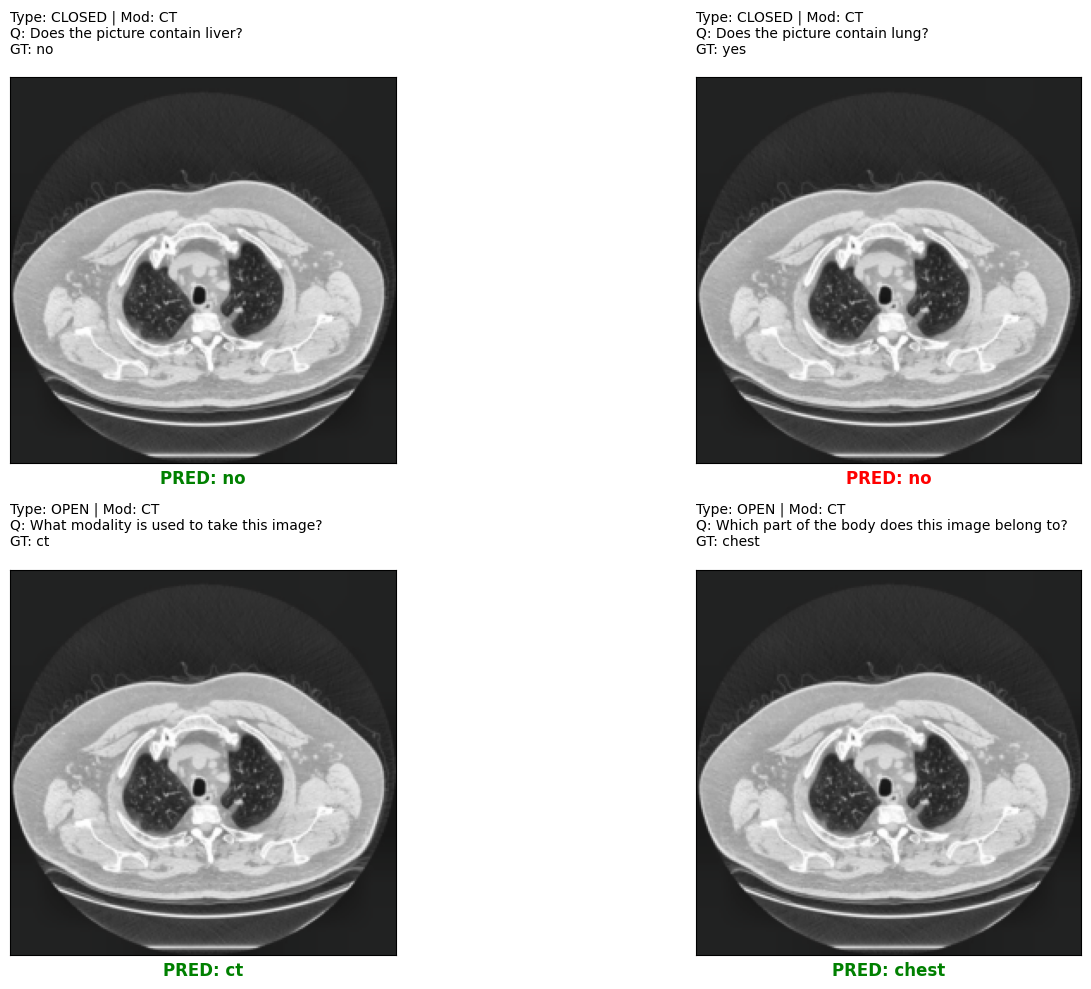

In [ ]:
import matplotlib.pyplot as plt

def display_medical_samples(model, dataset, checkpoint, device, num_samples=2):
    model.eval()
    # Inverse mapping for classes and words
    idx_to_ans = {v: k for k, v in checkpoint['ans_to_idx'].items()}

    # Separate samples by type
    closed_samples = [i for i, s in enumerate(dataset.samples) if s['answer_type'] == "CLOSED"]
    open_samples = [i for i, s in enumerate(dataset.samples) if s['answer_type'] == "OPEN"]

    selected_indices = closed_samples[:num_samples] + open_samples[:num_samples]

    plt.figure(figsize=(16, 10))

    for i, idx in enumerate(selected_indices):
        img_tensor, q_tensor, label_tensor = dataset[idx]
        meta = dataset.samples[idx]

        # Inference
        with torch.no_grad():
            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                output = model(img_tensor.unsqueeze(0).to(device), q_tensor.unsqueeze(0).to(device))
                pred_idx = output.argmax(1).item()

        pred_text = idx_to_ans.get(pred_idx, "UNKNOWN")
        gt_text = meta['answer'].lower()

        # Image Processing for display
        img_display = img_tensor.permute(1, 2, 0).cpu().numpy()
        # Un-normalize (ImageNet stats)
        img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_display = np.clip(img_display, 0, 1)

        # Plotting
        plt.subplot(2, 2, i + 1)
        plt.imshow(img_display)
        color = 'green' if pred_text == gt_text else 'red'

        title = f"Type: {meta['answer_type']} | Mod: {meta['modality']}\n"
        title += f"Q: {meta['question']}\n"
        title += f"GT: {gt_text}\n"
        plt.title(title, fontsize=10, loc='left')
        plt.xlabel(f"PRED: {pred_text}", fontsize=12, fontweight='bold', color=color)
        plt.xticks([]); plt.yticks([])

    plt.tight_layout()
    plt.show()



display_medical_samples(model, test_ds, checkpoint, DEVICE)


##  BLIP-2 LoRA Implementation (Salesforce/blip2-flan-t5-xl)

This implementation utilizes a modular, transformer-based approach for Medical Visual Question Answering, leveraging the **BLIP-2** architecture which aligns visual features with a Large Language Model (Flan-T5) via a Q-Former.

### 1. Model Architecture & Efficiency
*   **Backbone:** Uses `blip2-flan-t5-xl`, a powerful vision-language model.
*   **PEFT (LoRA):** Instead of full parameter tuning, it applies **Low-Rank Adaptation** to the attention layers (`query`, `value`, `key`). This allows for high-performance training on a 3-billion parameter model while only updating a fraction of the weights.
*   **Precision:** Configured for **BFloat16** to optimize memory usage on  A100 GPUs
*   **Frozen Components:** The Vision Model and Q-Former are frozen (`requires_grad_(False)`), focusing the learning entirely on the adapter layers and the decoder.

### 2. Specialized Medical Preprocessing
*   **CLAHE Enhancement:** Similar to the baseline model, it uses **Contrast Limited Adaptive Histogram Equalization** to normalize medical image lighting and contrast, ensuring the vision encoder can detect subtle pathological features in X-rays or CT scans.

### 3. Stratified Evaluation Framework
The `compute_metrics` function provides a deep-dive analysis of model performance:
*   **Global Metrics:** Tracks **ROUGE-1**, **BLEU-1**, and **BERTScore** for semantic accuracy.
*   **Stratified Metrics:** Breaks down accuracy and F1 scores by **Answer Type** (Closed vs. Open) and **Modality** (e.g., MRI, CT, X-ray), providing a granular view of where the model excels or struggles.


### 4. Training Hyperparameters Optimization
*   **Batch Size:** High-throughput configuration with a batch size of **64**, utilizing `adamw_torch_fused` for faster optimizer updates.
*   **Generation Control:** Uses `predict_with_generate` during evaluation to simulate real-world inference, restricted to a `max_new_tokens` of 16 to ensure concise medical answers.
*   **Early Stopping:** Monitoring `accuracy_all` with a patience of 3 epochs to ensure the model stops at the peak of its generalization ability.

### 5. Experiment Tracking
*   **WandB Integration:** Fully integrated with **Weights & Biases** under the project "MedVQA_2026_FlanT5_Final" to track loss curves and stratified metrics in real-time.


In [ ]:
import os, json, torch, wandb, numpy as np, cv2, evaluate
from PIL import Image
from datasets import Dataset
from collections import defaultdict, Counter
from transformers import (
    Blip2Processor, Blip2ForConditionalGeneration,
    Seq2SeqTrainingArguments, Seq2SeqTrainer,
    EarlyStoppingCallback, set_seed, GenerationConfig
)
from peft import LoraConfig, get_peft_model

# config
set_seed(42)
torch.set_float32_matmul_precision('high')

DRIVE_ROOT = "/content/drive/MyDrive/UM/slake_dataset/"
IMAGE_DIR = os.path.join(DRIVE_ROOT, "imgs/imgs")
FINAL_SAVE_DIR = "/content/drive/MyDrive/UM/AML/blip2_lora"
MODEL_ID = "Salesforce/blip2-flan-t5-xl"

# Load Metric Engines
rouge_metric = evaluate.load("rouge")
bertscore_metric = evaluate.load("bertscore")
bleu_metric = evaluate.load("bleu")

# loading data
def get_clahe_image(path):
    img = Image.open(path).convert("L")
    img_np = np.array(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return Image.fromarray(clahe.apply(img_np)).convert("RGB")

def load_slake(split):
    with open(os.path.join(DRIVE_ROOT, split), 'r') as f:
        data = [i for i in json.load(f) if i.get("q_lang") == "en"]
    return Dataset.from_dict({
        "image_path": [os.path.join(IMAGE_DIR, i['img_name']) for i in data],
        "question": [i['question'] for i in data],
        "answer": [str(i['answer']).lower().strip() for i in data],
        "answer_type": [i.get("answer_type", "OPEN").upper() for i in data],
        "modality": [i.get("modality", "unknown") for i in data]
    })

train_ds = load_slake("train.json")
val_ds = load_slake("validation.json")

# model setup (BF16 + LORA)
processor = Blip2Processor.from_pretrained(MODEL_ID)
model = Blip2ForConditionalGeneration.from_pretrained(
    MODEL_ID, torch_dtype=torch.bfloat16, device_map="auto"
)

if processor.tokenizer.pad_token_id is None:
    processor.tokenizer.pad_token = processor.tokenizer.eos_token
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = model.config.text_config.decoder_start_token_id

model.enable_input_require_grads()
model.vision_model.requires_grad_(False)
model.qformer.requires_grad_(False)

peft_config = LoraConfig(
    r=16, lora_alpha=32,
    target_modules=["query", "value", "key", "q", "v"],
    lora_dropout=0.05, bias="none"
)
model = get_peft_model(model, peft_config)

# custom trainer
class CustomTrainer(Seq2SeqTrainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):

        return super().compute_loss(model, inputs, return_outputs=return_outputs)

# metrics
def calculate_token_f1(p, r):
    p_tok, r_tok = p.split(), r.split()
    common = Counter(p_tok) & Counter(r_tok)
    num_same = sum(common.values())
    if num_same == 0: return 0.0
    prec, rec = num_same / (len(p_tok)+1e-8), num_same / (len(r_tok)+1e-8)
    return (2 * prec * rec) / (prec + rec + 1e-8)

def compute_metrics(eval_preds):
    preds, labels = eval_preds.predictions, eval_preds.label_ids
    preds = np.where(preds != -100, preds, processor.tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)

    decoded_preds = processor.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    clean_preds = [p.strip().lower() for p in decoded_preds]
    clean_labels = [l.strip().lower() for l in decoded_labels]

    # global scores
    rouge_res = rouge_metric.compute(predictions=clean_preds, references=clean_labels)
    bleu_res = bleu_metric.compute(predictions=clean_preds, references=clean_labels, max_order=1)
    bert_res = bertscore_metric.compute(predictions=clean_preds, references=clean_labels, lang="en",rescale_with_baseline=True)

    strat = defaultdict(list)
    # Ensure indices don't overflow if using a subset for evaluation
    max_idx = min(len(clean_preds), len(val_ds))

    for i in range(max_idx):
        p, r = clean_preds[i], clean_labels[i]
        meta = val_ds[i]
        f1 = calculate_token_f1(p, r)


        acc = 1 if (meta['answer_type'] == "CLOSED" and p == r) or (meta['answer_type'] != "CLOSED" and f1 >= 0.5) else 0

        for cat in ["all", f"type_{meta['answer_type']}", f"mod_{meta['modality'].replace(' ', '_')}"]:
            strat[f"accuracy_{cat}"].append(acc)
            strat[f"f1_{cat}"].append(f1)

    results = {
        "rouge1_global": rouge_res["rouge1"],
        "bleu1_global": bleu_res["bleu"],
        "token_f1_global": np.mean(strat["f1_all"]),
        "bertscore_f1_adjusted": np.mean(bert_res["f1"])
    }

    for k, v in strat.items():
        if "accuracy" in k or "f1" in k:
            results[k] = np.mean(v)

    return results


def collate_fn(batch):
    images = [get_clahe_image(item['image_path']) for item in batch]
    inputs = processor(images=images, text=[f"Question: {i['question']} Answer:" for i in batch],
                       return_tensors="pt", padding=True)
    inputs["pixel_values"].requires_grad = True
    labels = processor.tokenizer(text_target=[i['answer'] for i in batch],
                                 return_tensors="pt", padding=True).input_ids
    labels[labels == processor.tokenizer.pad_token_id] = -100
    return {**inputs, "labels": labels, "pixel_values": inputs["pixel_values"].to(torch.bfloat16)}

training_args = Seq2SeqTrainingArguments(
    output_dir=os.path.join(FINAL_SAVE_DIR, "checkpoints"),
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    predict_with_generate=True,
    generation_config=GenerationConfig(
        max_new_tokens=16,
        pad_token_id=processor.tokenizer.pad_token_id,
        decoder_start_token_id=model.config.decoder_start_token_id
    ),
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    num_train_epochs=10,
    bf16=True,
    logging_steps=10,
    optim="adamw_torch_fused",
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy_all",
    remove_unused_columns=False,
    report_to="wandb"
)

trainer = CustomTrainer(
    model=model, args=training_args, train_dataset=train_ds, eval_dataset=val_ds,
    data_collator=collate_fn, compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(3)]
)


wandb.init(project="MedVQA_2026_FlanT5_Final", name="Thesis_Success_Metrics")
trainer.train()
trainer.model.save_pretrained(FINAL_SAVE_DIR)
processor.save_pretrained(FINAL_SAVE_DIR)


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.
wandb: Currently logged in as: johnmulu25 (johnmulu25-pri) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss,Rouge1 Global,Bleu1 Global,Token F1 Global,Bertscore F1 Adjusted,Accuracy All,F1 All,Accuracy Type Open,F1 Type Open,Accuracy Mod Mri,F1 Mod Mri,Accuracy Type Closed,F1 Type Closed,Accuracy Mod Ct,F1 Mod Ct,Accuracy Mod X-ray,F1 Mod X-ray
1,1.000900,0.976900,0.573061,0.448640,0.567152,0.814279,0.549858,0.567152,0.486529,0.512749,0.515021,0.521854,0.644550,0.648499,0.529046,0.532296,0.603550,0.648084
2,0.880900,0.698745,0.649339,0.553746,0.644970,0.842462,0.626781,0.644970,0.573693,0.597971,0.583691,0.601757,0.706161,0.715245,0.599585,0.607553,0.695266,0.728116
3,0.656700,0.572505,0.690913,0.606263,0.685045,0.864381,0.674264,0.685045,0.643423,0.655339,0.656652,0.668700,0.720379,0.729463,0.632780,0.642561,0.745562,0.756896
4,0.548100,0.500221,0.707089,0.645848,0.701713,0.866684,0.691358,0.701713,0.660856,0.672061,0.669528,0.687723,0.736967,0.746051,0.668050,0.675909,0.739645,0.748154
5,0.523400,0.445481,0.725852,0.657865,0.719131,0.882644,0.712251,0.719131,0.683043,0.692412,0.699571,0.693908,0.755924,0.759084,0.699170,0.705873,0.739645,0.755425
6,0.506100,0.416098,0.731884,0.685414,0.725405,0.885587,0.719848,0.725405,0.694136,0.701296,0.703863,0.707174,0.758294,0.761453,0.709544,0.714587,0.745562,0.753398
7,0.462900,0.389949,0.737532,0.708454,0.732455,0.893261,0.727445,0.732455,0.708399,0.714646,0.721030,0.714503,0.755924,0.759084,0.697095,0.704144,0.775148,0.785201
8,0.424400,0.373438,0.749448,0.710258,0.743111,0.900180,0.736942,0.743111,0.719493,0.727674,0.742489,0.738828,0.763033,0.766193,0.705394,0.712201,0.778107,0.790141
9,0.470000,0.365039,0.748727,0.713500,0.741795,0.899578,0.735992,0.741795,0.717908,0.725479,0.742489,0.737788,0.763033,0.766193,0.705394,0.712201,0.775148,0.786760
10,0.417000,0.362959,0.749324,0.714982,0.742196,0.898042,0.735992,0.742196,0.714739,0.722978,0.733906,0.731493,0.767773,0.770932,0.707469,0.714276,0.778107,0.789389


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


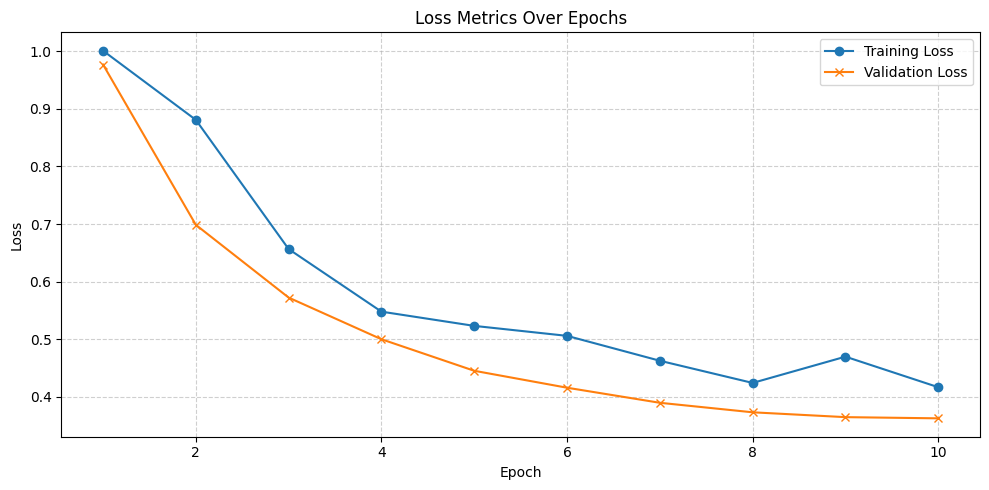

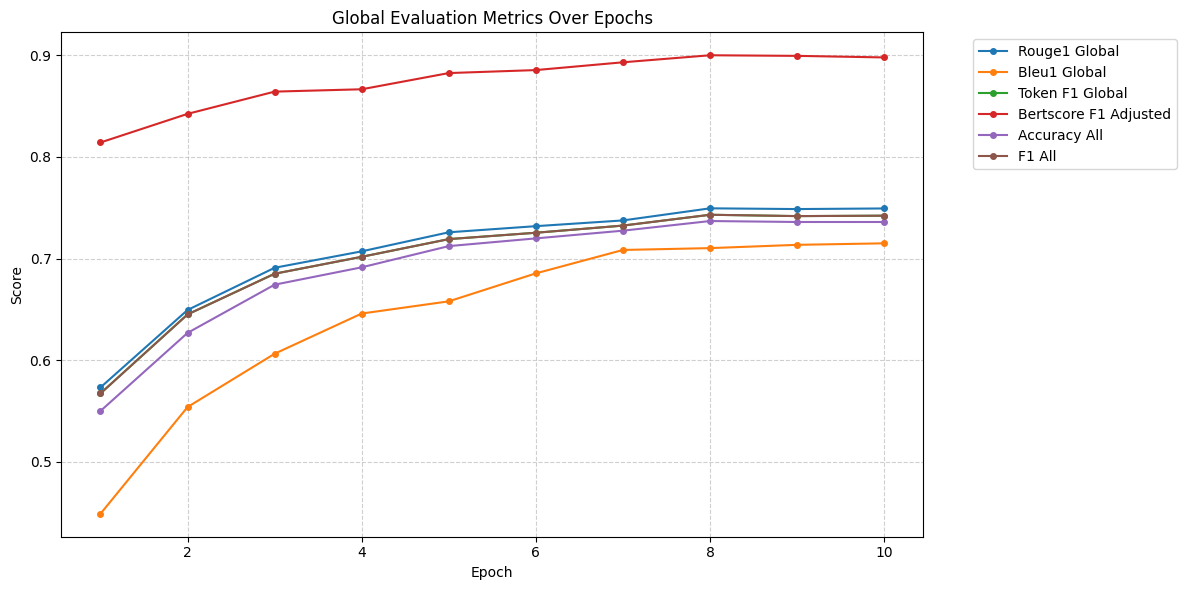

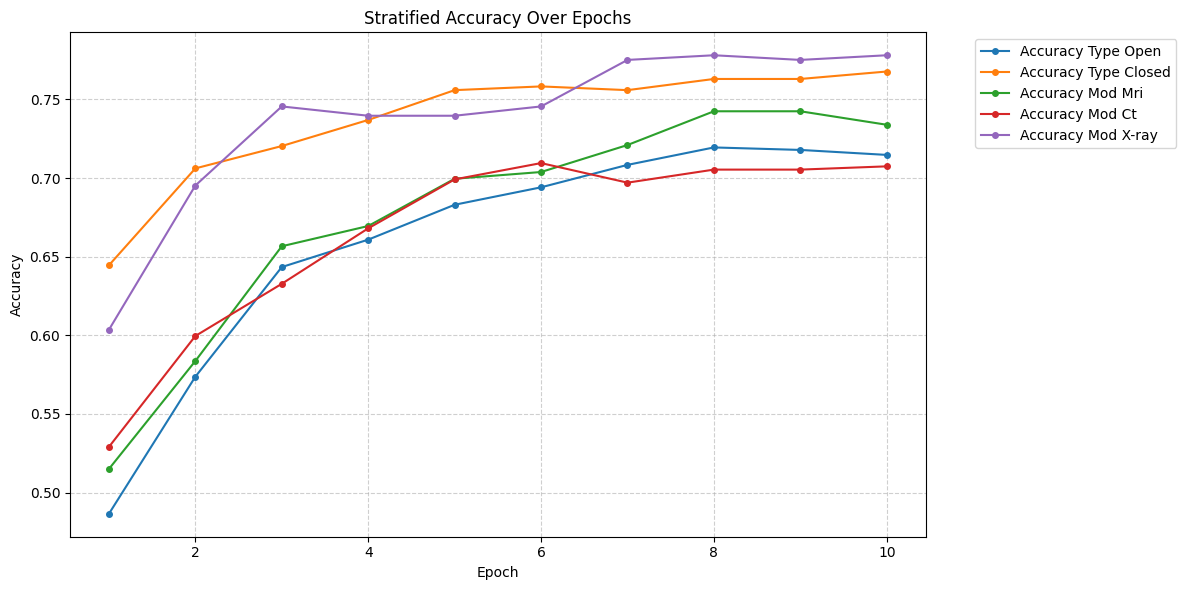

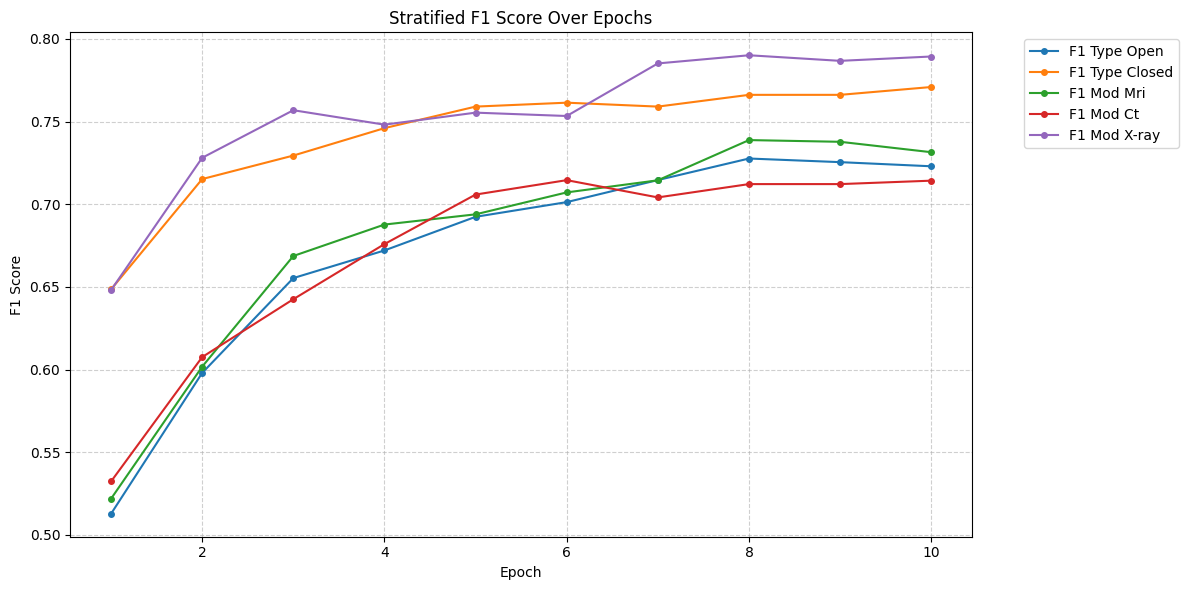

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import re

log_data = """
Epoch	Training Loss	Validation Loss	Rouge1 Global	Bleu1 Global	Token F1 Global	Bertscore F1 Adjusted	Accuracy All	F1 All	Accuracy Type Open	F1 Type Open	Accuracy Mod Mri	F1 Mod Mri	Accuracy Type Closed	F1 Type Closed	Accuracy Mod Ct	F1 Mod Ct	Accuracy Mod X-ray	F1 Mod X-ray
1	1.000900	0.976900	0.573061	0.448640	0.567152	0.814279	0.549858	0.567152	0.486529	0.512749	0.515021	0.521854	0.644550	0.648499	0.529046	0.532296	0.603550	0.648084
2	0.880900	0.698745	0.649339	0.553746	0.644970	0.842462	0.626781	0.644970	0.573693	0.597971	0.583691	0.601757	0.706161	0.715245	0.599585	0.607553	0.695266	0.728116
3	0.656700	0.572505	0.690913	0.606263	0.685045	0.864381	0.674264	0.685045	0.643423	0.655339	0.656652	0.668700	0.720379	0.729463	0.632780	0.642561	0.745562	0.756896
4	0.548100	0.500221	0.707089	0.645848	0.701713	0.866684	0.691358	0.701713	0.660856	0.672061	0.669528	0.687723	0.736967	0.746051	0.668050	0.675909	0.739645	0.748154
5	0.523400	0.445481	0.725852	0.657865	0.719131	0.882644	0.712251	0.719131	0.683043	0.692412	0.699571	0.693908	0.755924	0.759084	0.699170	0.705873	0.739645	0.755425
6	0.506100	0.416098	0.731884	0.685414	0.725405	0.885587	0.719848	0.725405	0.694136	0.701296	0.703863	0.707174	0.758294	0.761453	0.709544	0.714587	0.745562	0.753398
7	0.462900	0.389949	0.737532	0.708454	0.732455	0.893261	0.727445	0.732455	0.708399	0.714646	0.721030	0.714503	0.755924	0.759084	0.697095	0.704144	0.775148	0.785201
8	0.424400	0.373438	0.749448	0.710258	0.743111	0.900180	0.736942	0.743111	0.719493	0.727674	0.742489	0.738828	0.763033	0.766193	0.705394	0.712201	0.778107	0.790141
9	0.470000	0.365039	0.748727	0.713500	0.741795	0.899578	0.735992	0.741795	0.717908	0.725479	0.742489	0.737788	0.763033	0.766193	0.705394	0.712201	0.775148	0.786760
10	0.417000	0.362959	0.749324	0.714982	0.742196	0.898042	0.735992	0.742196	0.714739	0.722978	0.733906	0.731493	0.767773	0.770932	0.707469	0.714276	0.778107	0.789389"""

# Parse the log data
from io import StringIO
df = pd.read_csv(StringIO(log_data), sep='\t')

# --- Plot 1: Loss Metrics Over Epochs ---
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Training Loss'], label='Training Loss', marker='o')
plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss', marker='x')
plt.title('Loss Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Plot 2: Global Evaluation Metrics Over Epochs ---
plt.figure(figsize=(12, 6))
metrics_global = ['Rouge1 Global', 'Bleu1 Global', 'Token F1 Global', 'Bertscore F1 Adjusted', 'Accuracy All', 'F1 All']
for metric in metrics_global:
    plt.plot(df['Epoch'], df[metric], label=metric, marker='o', markersize=4)
plt.title('Global Evaluation Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Plot 3: Stratified Accuracy Metrics Over Epochs ---
plt.figure(figsize=(12, 6))
metrics_strat_acc = ['Accuracy Type Open', 'Accuracy Type Closed', 'Accuracy Mod Mri', 'Accuracy Mod Ct', 'Accuracy Mod X-ray']
for metric in metrics_strat_acc:
    plt.plot(df['Epoch'], df[metric], label=metric, marker='o', markersize=4)
plt.title('Stratified Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Plot 4: Stratified F1 Metrics Over Epochs ---
plt.figure(figsize=(12, 6))
metrics_strat_f1 = ['F1 Type Open', 'F1 Type Closed', 'F1 Mod Mri', 'F1 Mod Ct', 'F1 Mod X-ray']
for metric in metrics_strat_f1:
    plt.plot(df['Epoch'], df[metric], label=metric, marker='o', markersize=4)
plt.title('Stratified F1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Loading processor and base model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading adapters from: /content/drive/MyDrive/UM/AML/blip2_lora...


The model is already on multiple devices. Skipping the move to device specified in `args`.



*** Running Test Set Evaluation ***


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ACCURACY AND METRIC SUMMARY
eval_loss                          : 0.3915
eval_model_preparation_time        : 0.0178
eval_rouge1                        : 0.7481
eval_bleu1                         : 0.6867
eval_bertscore_f1_rescaled         : 0.8868
eval_accuracy_all                  : 0.7370
eval_f1_all                        : 0.7433
eval_accuracy_type_OPEN            : 0.7194
eval_f1_type_OPEN                  : 0.7297
eval_accuracy_mod_CT               : 0.6674
eval_f1_mod_CT                     : 0.6717
eval_accuracy_type_CLOSED          : 0.7644
eval_f1_type_CLOSED                : 0.7644
eval_accuracy_mod_X-Ray            : 0.7950
eval_f1_mod_X-Ray                  : 0.8151
eval_accuracy_mod_MRI              : 0.7895
eval_f1_mod_MRI                    : 0.7779
eval_runtime                       : 36.4649
eval_samples_per_second            : 29.0970
eval_steps_per_second              : 1.8370

UNIQUE VISUAL PREDICTION SAMPLES


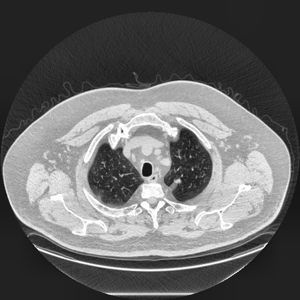

Question: Does the picture contain liver?
Ground Truth: no
Model Prediction: no
Modality: CT
Image Source: source.jpg
--------------------------------------------------


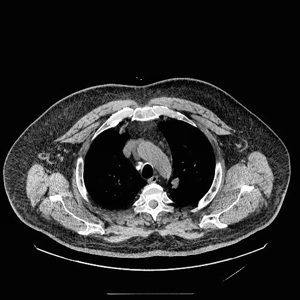

Question: Does the picture contain liver?
Ground Truth: no
Model Prediction: yes
Modality: CT
Image Source: source.jpg
--------------------------------------------------


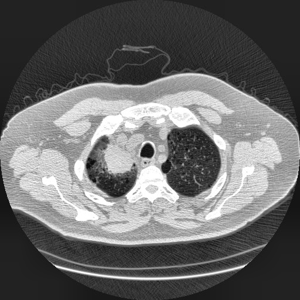

Question: Does the picture contain liver?
Ground Truth: no
Model Prediction: no
Modality: CT
Image Source: source.jpg
--------------------------------------------------


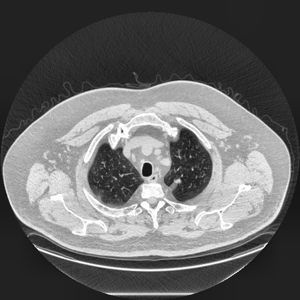

Question: What modality is used to take this image?
Ground Truth: ct
Model Prediction: ct
Modality: CT
Image Source: source.jpg
--------------------------------------------------


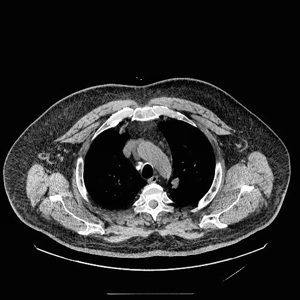

Question: What modality is used to take this image?
Ground Truth: ct
Model Prediction: ct
Modality: CT
Image Source: source.jpg
--------------------------------------------------


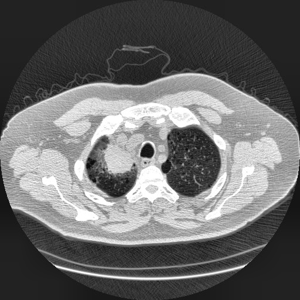

Question: What modality is used to take this image?
Ground Truth: ct
Model Prediction: ct
Modality: CT
Image Source: source.jpg
--------------------------------------------------


In [ ]:
import os, json, torch, numpy as np, cv2, evaluate
from PIL import Image
from datasets import Dataset
from collections import defaultdict, Counter
from transformers import (
    Blip2Processor, Blip2ForConditionalGeneration,
    Seq2SeqTrainingArguments, Seq2SeqTrainer, GenerationConfig
)
from peft import PeftModel
from IPython.display import display, HTML

#   configurayion
torch.set_float32_matmul_precision('high')
DRIVE_ROOT = "/content/drive/MyDrive/UM/slake_dataset/"
IMAGE_DIR = os.path.join(DRIVE_ROOT, "imgs/imgs")
LOAD_DIR = "/content/drive/MyDrive/UM/AML/blip2_lora"
BASE_MODEL_ID = "Salesforce/blip2-flan-t5-xl"

# Load Metric Engines
rouge_metric = evaluate.load("rouge")
bertscore_metric = evaluate.load("bertscore")
bleu_metric = evaluate.load("bleu")

# data loading
def get_clahe_image(path):
    """Loads a specific image path and applies CLAHE enhancement."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Image not found at: {path}")
    img = Image.open(path).convert("L")
    img_np = np.array(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return Image.fromarray(clahe.apply(img_np)).convert("RGB")

def load_slake_test(split_file):
    with open(os.path.join(DRIVE_ROOT, split_file), 'r') as f:
        data = [i for i in json.load(f) if i.get("q_lang") == "en"]
    return Dataset.from_dict({
        "image_path": [os.path.join(IMAGE_DIR, i['img_name']) for i in data],
        "question": [i['question'] for i in data],
        "answer": [str(i['answer']).lower().strip() for i in data],
        "answer_type": [i.get("answer_type", "OPEN").upper() for i in data],
        "modality": [i.get("modality", "unknown") for i in data]
    })

test_ds = load_slake_test("test.json")

# load saved model and processor
print(f"Loading processor and base model...")
processor = Blip2Processor.from_pretrained(LOAD_DIR)
base_model = Blip2ForConditionalGeneration.from_pretrained(
    BASE_MODEL_ID, torch_dtype=torch.bfloat16, device_map="auto"
)

print(f"Loading adapters from: {LOAD_DIR}...")
model = PeftModel.from_pretrained(base_model, LOAD_DIR)
model.eval()

# sync configuration
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = model.config.text_config.decoder_start_token_id

# accuracy metrics
def calculate_token_f1(p, r):
    p_tok, r_tok = p.split(), r.split()
    common = Counter(p_tok) & Counter(r_tok)
    num_same = sum(common.values())
    if num_same == 0: return 0.0
    prec, rec = num_same / (len(p_tok)+1e-8), num_same / (len(r_tok)+1e-8)
    return (2 * prec * rec) / (prec + rec + 1e-8)

def compute_metrics(eval_preds):
    preds, labels = eval_preds.predictions, eval_preds.label_ids
    preds = np.where(preds != -100, preds, processor.tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)

    decoded_preds = processor.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    clean_preds = [p.strip().lower() for p in decoded_preds]
    clean_labels = [l.strip().lower() for l in decoded_labels]

    rouge_res = rouge_metric.compute(predictions=clean_preds, references=clean_labels)
    bleu_res = bleu_metric.compute(predictions=clean_preds, references=clean_labels, max_order=1)
    bert_res = bertscore_metric.compute(predictions=clean_preds, references=clean_labels, lang="en", rescale_with_baseline=True)

    strat = defaultdict(list)
    for i in range(len(clean_preds)):
        p, r = clean_preds[i], clean_labels[i]
        meta = test_ds[i]
        f1 = calculate_token_f1(p, r)
        acc = 1 if (meta['answer_type'] == "CLOSED" and p == r) or (meta['answer_type'] != "CLOSED" and f1 >= 0.5) else 0

        for cat in ["all", f"type_{meta['answer_type']}", f"mod_{meta['modality'].replace(' ', '_')}"]:
            strat[f"accuracy_{cat}"].append(acc)
            strat[f"f1_{cat}"].append(f1)

    results = {
        "rouge1": rouge_res["rouge1"],
        "bleu1": bleu_res["bleu"],
        "bertscore_f1_rescaled": np.mean(bert_res["f1"])
    }
    for k, v in strat.items(): results[k] = np.mean(v)
    return results


def collate_fn(batch):
    # dynamically loads the specific image for each batch item
    images = [get_clahe_image(item['image_path']) for item in batch]
    inputs = processor(images=images, text=[f"Question: {i['question']} Answer:" for i in batch],
                       return_tensors="pt", padding=True)
    labels = processor.tokenizer(text_target=[i['answer'] for i in batch],
                                 return_tensors="pt", padding=True).input_ids
    labels[labels == processor.tokenizer.pad_token_id] = -100
    return {**inputs, "labels": labels, "pixel_values": inputs["pixel_values"].to(torch.bfloat16)}

test_args = Seq2SeqTrainingArguments(
    output_dir="./temp_test",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    generation_config=GenerationConfig(
        max_new_tokens=16,
        pad_token_id=processor.tokenizer.pad_token_id,
        decoder_start_token_id=model.config.decoder_start_token_id
    ),
    bf16=True,
    remove_unused_columns=False
)

trainer = Seq2SeqTrainer(
    model=model, args=test_args, eval_dataset=test_ds,
    data_collator=collate_fn, compute_metrics=compute_metrics
)

print("\n*** Running Test Set Evaluation ***")
metrics = trainer.evaluate()

# disply result and sample
print("\n" + "="*50)
print("ACCURACY AND METRIC SUMMARY")
print("="*50)
for k, v in metrics.items():
    print(f"{k:35}: {v:.4f}")

print("\n" + "="*50)
print("UNIQUE VISUAL PREDICTION SAMPLES")
print("="*50)

for target_type in ["CLOSED", "OPEN"]:
    display(HTML(f"<h3 style='color: darkgreen;'>Unique Samples: {target_type} Questions</h3>"))

    # Get indices for this type and select 3 distinct ones
    indices = [i for i, x in enumerate(test_ds["answer_type"]) if x == target_type]

    # Pick indices that point to different images to ensure variety
    seen_images = set()
    unique_indices = []
    for idx in indices:
        path = test_ds[idx]['image_path']
        if path not in seen_images:
            unique_indices.append(idx)
            seen_images.add(path)
        if len(unique_indices) == 3: break

    for idx in unique_indices:
        item = test_ds[idx]
        image_pil = get_clahe_image(item['image_path'])

        # Specific Inference for this unique image
        inputs = processor(images=image_pil, text=f"Question: {item['question']} Answer:", return_tensors="pt").to("cuda", torch.bfloat16)
        out = model.generate(**inputs, max_new_tokens=16)

        # Decode individual generation
        pred = processor.decode(out[0], skip_special_tokens=True).strip().lower()

        # Display Unique Image and Results
        image_pil.thumbnail((300, 300))
        display(image_pil)

        print(f"Question: {item['question']}")
        print(f"Ground Truth: {item['answer']}")
        print(f"Model Prediction: {pred}")
        print(f"Modality: {item['modality']}")
        print(f"Image Source: {os.path.basename(item['image_path'])}")
        print("-" * 50)


##**Experiment 3: LLAVA Model**

## LLAVA:- Implementation Overview

This notebook implements a fine-tuning pipeline for the **LLaVA-1.5-7B** multimodal model, specifically tailored for the **SLAKE Medical VQA** dataset using best practices.

### 1. Environment & Setup
*   **Optimization:** Utilizes `flash-attn` (Flash Attention 2) and `bitsandbytes` for memory-efficient training.
*   **Workspace:** Configures Google Drive for persistent storage of dataset assets and model checkpoints for a 2026 thesis project.

### 2. Data Preprocsseing
*   **Filtering:** Isolates English-language samples from the SLAKE dataset.
*   **Prompt Engineering:** Formats data into a conversation style:  
    `USER: <image>\n{question}\nASSISTANT: {answer}`.
*   **Masking:** Implements a custom `collate_fn` that applies **label masking** (using `-100`) to the prompt/instructions. This ensures the model only learns to generate the *answer*, not the *question*.

### 3. Model Configuration & PEFT
*   **Precision:** Loads the model in `bfloat16` to leverage modern GPU (e.g., A100/H100) performance.
*   **LoRA (Low-Rank Adaptation):** Applies PEFT with `r=16` and `alpha=32` targeting the Query and Value projections. This allows for efficient training with significantly lower VRAM requirements.
*   **Memory Management:** Enables Gradient Checkpointing to allow for larger batch sizes.

### 4. Evaluation Framework
Calculates a comprehensive suite of metrics to validate medical accuracy:
*   **Exact Match (EM) & Token F1:** For rigid and flexible answer matching.
*   **BLEU-1 & ROUGE-L:** For linguistic overlap.
*   **BERTScore:** For semantic similarity using deep learning embeddings.

### 5. Training & test
*   **Hyperparameters:** Uses a `5e-5` learning rate with a **Cosine Decay Scheduler** over 10 epochs.
*   **Early Stopping:** Monitors `token_f1` with a patience of 2 epochs to prevent overfitting.
*   **Artifacts:** The final step performs a **Merge and Unload** operation, combining the LoRA weights into the base LLaVA model for a single, deployable `.bin` file.


In [ ]:
# Training MEDICAL VQA (SLAKE) - HF-LLAVA Implementation
# libraries
!pip install -q -U transformers datasets peft accelerate bitsandbytes trl wandb evaluate rouge_score bert_score flash-attn

import os, torch, wandb, numpy as np, json, evaluate
from google.colab import drive
from PIL import Image
from datasets import Dataset
from collections import Counter
from transformers import (
    AutoProcessor, LlavaForConditionalGeneration,
    TrainingArguments, set_seed, EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer

#config
drive.mount('/content/drive')
set_seed(42)
torch.backends.cuda.matmul.allow_tf32 = True

DRIVE_ROOT = "/content/drive/MyDrive/LLaVA_Med_Slake_Thesis_2026/slake_dataset"
FINAL_SAVE_DIR = "/content/drive/MyDrive/LLaVA_Med_Slake_Thesis_2026/SOTA_FINAL_LLAVA_2026_now"
os.makedirs(FINAL_SAVE_DIR, exist_ok=True)

# data pipe;ine
def load_slake_research(split_json):
    with open(os.path.join(DRIVE_ROOT, split_json), 'r') as f:
        data = json.load(f)
    en_data = [i for i in data if i.get("q_lang") == "en"]
    formatted = [{"image": os.path.join(DRIVE_ROOT, "imgs", i['img_name']),
                  "content": f"USER: <image>\n{i['question']}\nASSISTANT: {i['answer']}"} for i in en_data]
    return Dataset.from_list(formatted)

train_ds = load_slake_research("train.json")
val_ds = load_slake_research("validation.json")


# model loading and flash attention 2
MODEL_ID = "llava-hf/llava-1.5-7b-hf"
processor = AutoProcessor.from_pretrained(MODEL_ID)
model = LlavaForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    device_map="auto",
    attn_implementation="flash_attention_2"
)

# Optimization: Gradient Checkpointing & Cache Management
model.config.use_cache = False
model.gradient_checkpointing_enable()

# PEFT (LoRA Rank 16)
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)

# accuracy metrics
rouge_m, bleu_m, bert_m = evaluate.load("rouge"), evaluate.load("bleu"), evaluate.load("bertscore")

def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple): logits = logits[0]
    return logits.argmax(dim=-1)

def compute_metrics(eval_preds):
    preds, labels = eval_preds.predictions, eval_preds.label_ids
    preds[preds == -100] = processor.tokenizer.pad_token_id
    labels[labels == -100] = processor.tokenizer.pad_token_id

    decoded_preds = processor.tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)

    ems = [1 if p.strip().lower() == l.strip().lower() else 0 for p, l in zip(decoded_preds, decoded_labels)]

    f1_list = []
    for p, l in zip(decoded_preds, decoded_labels):
        p_t, r_t = p.split(), l.split()
        common = Counter(p_t) & Counter(r_t)
        num_same = sum(common.values())
        f1_list.append((2 * (num_same/len(p_t)) * (num_same/len(r_t))) / ((num_same/len(p_t)) + (num_same/len(r_t))) if num_same > 0 else 0)

    b1 = bleu_m.compute(predictions=decoded_preds, references=[[l] for l in decoded_labels], max_order=1)
    r = rouge_m.compute(predictions=decoded_preds, references=decoded_labels)
    bert_res = bert_m.compute(predictions=decoded_preds, references=decoded_labels, lang="en")

    return {
        "exact_match": np.mean(ems), "token_f1": np.mean(f1_list),
        "bleu1": b1["bleu"], "rouge1": r["rouge1"], "rougeL": r["rougeL"],
        "bertscore_f1": np.mean(bert_res["f1"])
    }

# prompt masking
def collate_fn(examples):
    images = [Image.open(e["image"]).convert("RGB") for e in examples]
    texts = [e["content"] for e in examples]
    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)
    labels = batch["input_ids"].clone()
    for i, text in enumerate(texts):
        prompt_text = text.split("ASSISTANT:")[0] + "ASSISTANT:"
        prompt_len = len(processor.tokenizer(prompt_text, add_special_tokens=False).input_ids)
        labels[i, :prompt_len] = -100
    labels[batch["input_ids"] == processor.tokenizer.pad_token_id] = -100
    batch["labels"] = labels
    return batch

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Metrics from the last run (MAX_NEW_TOKENS = 10) in cell 9482fa21
metrics_data = {
    "Metric": ["EM", "F1", "BLEU1", "ROUGE-L", "BERT"],
    "Value": [0.0858, 0.2391, 0.1765, 0.3652, 0.8608]
}
df_metrics = pd.DataFrame(metrics_data)

plt.figure(figsize=(10, 6))
plt.bar(df_metrics["Metric"], df_metrics["Value"], color=['skyblue', 'lightcoral', 'lightgreen', 'orange', 'mediumpurple'])
plt.xlabel("Metric")
plt.ylabel("Value")
plt.title("Final Test Metrics (MAX_NEW_TOKENS = 10)")
plt.ylim(0, 1) # Metrics typically range from 0 to 1

# Add value labels on top of bars
for index, row in df_metrics.iterrows():
    plt.text(row["Metric"], row["Value"] + 0.02, f'{row["Value"]:.4f}', color='black', ha="center")

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:

# training arguments/ hyperparameters
training_args = TrainingArguments(
    output_dir=FINAL_SAVE_DIR,
    num_train_epochs=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=50,
    lr_scheduler_type="cosine",
    per_device_train_batch_size=12,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    dataloader_num_workers=8,
    dataloader_pin_memory=True,
    dataloader_persistent_workers=True,
    bf16=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=5,
    report_to="wandb",
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=True,
    metric_for_best_model="token_f1"
)

# trainer
trainer = SFTTrainer(
    model=model, train_dataset=train_ds, eval_dataset=val_ds,
    args=training_args, data_collator=collate_fn, compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

wandb.init(project="LLaVA-Slake-Final-2026", name="A100-SOTA-V2-Persistent")
trainer.train()

# saving model
model.save_pretrained(os.path.join(FINAL_SAVE_DIR, "lora_adapter"))
merged = model.merge_and_unload()
merged.save_pretrained(os.path.join(FINAL_SAVE_DIR, "LLAVA_SLAKE_MERGED"))
processor.save_pretrained(os.path.join(FINAL_SAVE_DIR, "LLAVA_SLAKE_MERGED"))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:2111: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
The model is already on multiple devices. Skipping the move to device specified in `args`.
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.
wandb: Currently logged in as: johnmulu25 (johnmulu25-pri) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch,Training Loss,Validation Loss,Exact Match,Token F1,Bleu1,Rouge1,Rougel,Bertscore F1
1,3.807300,3.804548,0.000000,0.345357,0.297371,0.392174,0.383434,0.836882
2,3.756000,3.755530,0.000000,0.459007,0.405786,0.500379,0.495346,0.852070
3,3.747200,3.746397,0.000000,0.498829,0.438438,0.543728,0.540742,0.856451
4,3.743100,3.742622,0.000000,0.519230,0.450595,0.558293,0.556173,0.859279
5,3.742800,3.741155,0.000000,0.517951,0.450036,0.559942,0.558349,0.860636
6,3.739900,3.737821,0.000000,0.530299,0.457182,0.565712,0.564239,0.860604
7,3.746400,3.740207,0.000000,0.533582,0.459367,0.567379,0.565833,0.860586
8,3.737100,3.736557,0.000000,0.535841,0.461305,0.571633,0.569785,0.861342
9,3.741900,3.739794,0.000000,0.534768,0.460818,0.571120,0.569664,0.861270


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/chec

Epoch,Training Loss,Validation Loss,Exact Match,Token F1,Bleu1,Rouge1,Rougel,Bertscore F1
1,3.807300,3.804548,0.000000,0.345357,0.297371,0.392174,0.383434,0.836882
2,3.756000,3.755530,0.000000,0.459007,0.405786,0.500379,0.495346,0.852070
3,3.747200,3.746397,0.000000,0.498829,0.438438,0.543728,0.540742,0.856451
4,3.743100,3.742622,0.000000,0.519230,0.450595,0.558293,0.556173,0.859279
5,3.742800,3.741155,0.000000,0.517951,0.450036,0.559942,0.558349,0.860636
6,3.739900,3.737821,0.000000,0.530299,0.457182,0.565712,0.564239,0.860604
7,3.746400,3.740207,0.000000,0.533582,0.459367,0.567379,0.565833,0.860586
8,3.737100,3.736557,0.000000,0.535841,0.461305,0.571633,0.569785,0.861342
9,3.741900,3.739794,0.000000,0.534768,0.460818,0.571120,0.569664,0.861270
10,3.742900,3.739552,0.000000,0.535752,0.461791,0.572078,0.570597,0.861320


['/content/drive/MyDrive/LLaVA_Med_Slake_Thesis_2026/SOTA_FINAL_LLAVA_2026_now/LLAVA_SLAKE_MERGED/processor_config.json']

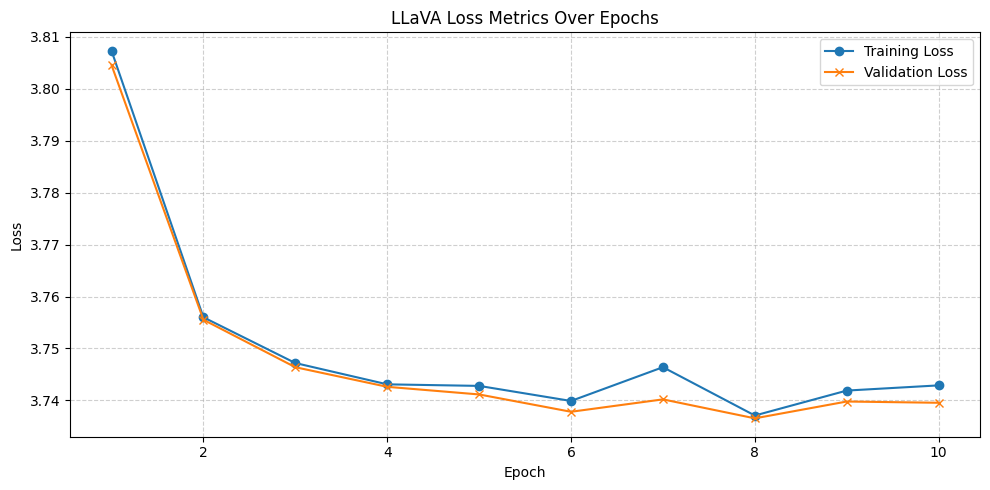

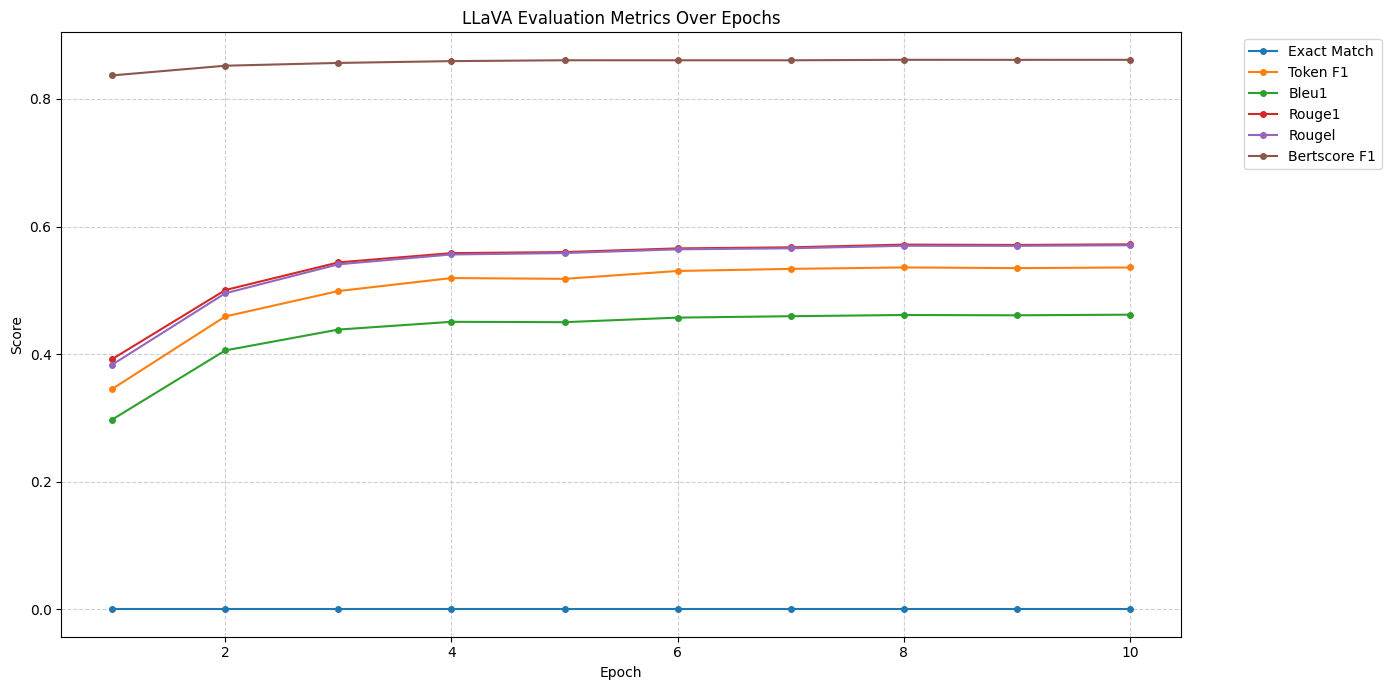

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

log_data = """
Epoch	Training Loss	Validation Loss	Exact Match	Token F1	Bleu1	Rouge1	Rougel	Bertscore F1
1	3.807300	3.804548	0.000000	0.345357	0.297371	0.392174	0.383434	0.836882
2	3.756000	3.755530	0.000000	0.459007	0.405786	0.500379	0.495346	0.852070
3	3.747200	3.746397	0.000000	0.498829	0.438438	0.543728	0.540742	0.856451
4	3.743100	3.742622	0.000000	0.519230	0.450595	0.558293	0.556173	0.859279
5	3.742800	3.741155	0.000000	0.517951	0.450036	0.559942	0.558349	0.860636
6	3.739900	3.737821	0.000000	0.530299	0.457182	0.565712	0.564239	0.860604
7	3.746400	3.740207	0.000000	0.533582	0.459367	0.567379	0.565833	0.860586
8	3.737100	3.736557	0.000000	0.535841	0.461305	0.571633	0.569785	0.861342
9	3.741900	3.739794	0.000000	0.534768	0.460818	0.571120	0.569664	0.861270
10	3.742900	3.739552	0.000000	0.535752	0.461791	0.572078	0.570597	0.861320"""

df = pd.read_csv(StringIO(log_data), sep='\t')

# --- Plot 1: Loss Metrics Over Epochs ---
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Training Loss'], label='Training Loss', marker='o')
plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss', marker='x')
plt.title('LLaVA Loss Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Plot 2: Evaluation Metrics Over Epochs ---
plt.figure(figsize=(14, 7))
metrics_to_plot = ['Exact Match', 'Token F1', 'Bleu1', 'Rouge1', 'Rougel', 'Bertscore F1']

for metric in metrics_to_plot:
    plt.plot(df['Epoch'], df[metric], label=metric, marker='o', markersize=4)

plt.title('LLaVA Evaluation Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


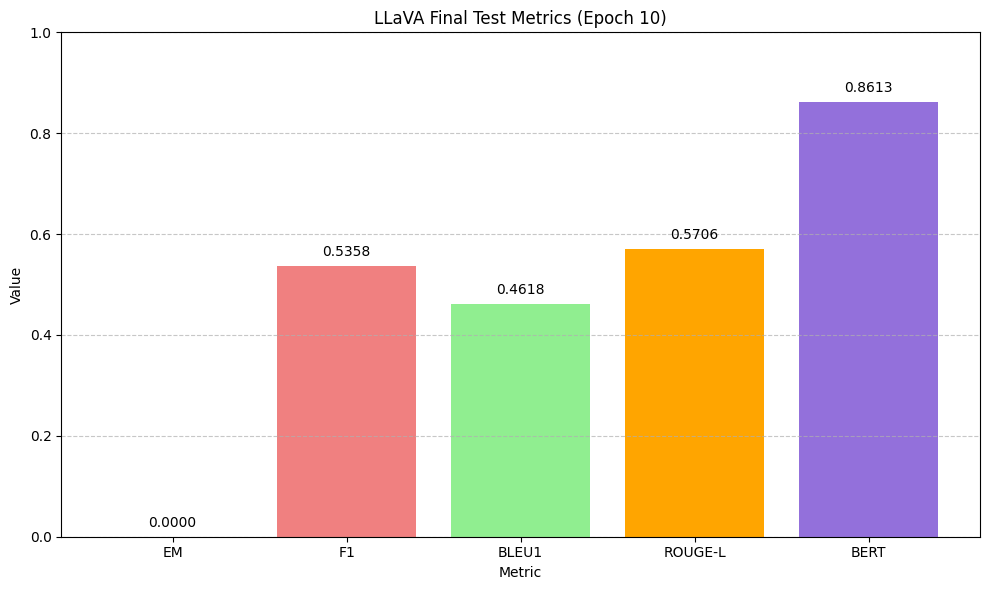

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Metrics from the last run (MAX_NEW_TOKENS = 10)
metrics_data = {
    "Metric": ["EM", "F1", "BLEU1", "ROUGE-L", "BERT"],
    "Value": [0.000000, 0.535752, 0.461791, 0.570597, 0.861320]
}
df_metrics = pd.DataFrame(metrics_data)

plt.figure(figsize=(10, 6))
plt.bar(df_metrics["Metric"], df_metrics["Value"], color=['skyblue', 'lightcoral', 'lightgreen', 'orange', 'mediumpurple'])
plt.xlabel("Metric")
plt.ylabel("Value")
plt.title("LLaVA Final Test Metrics (Epoch 10)")
plt.ylim(0, 1) # Metrics typically range from 0 to 1

# Add value labels on top of bars
for index, row in df_metrics.iterrows():
    plt.text(row["Metric"], row["Value"] + 0.02, f'{row["Value"]:.4f}', color='black', ha="center")

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The plots above illustrate the training progress of the LLaVA model:

*   **Loss Metrics Over Epochs**: This plot shows how the training and validation loss changed throughout the training process.
*   **Evaluation Metrics Over Epochs**: This plot displays the trends of various evaluation metrics (Exact Match, Token F1, Bleu1, Rouge1, Rougel, Bertscore F1) over the epochs, providing insights into the model's performance on different aspects of VQA.

In [ ]:
import os, evaluate, re
from tqdm import tqdm
from collections import Counter, defaultdict

# hardware ecc
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision('high')

# saved model path
DRIVE_ROOT = "/content/drive/MyDrive/LLaVA_Med_Slake_Thesis_2026/slake_dataset"
BASE_MODEL_ID = "llava-hf/llava-1.5-7b-hf"
LORA_PATH = "/content/drive/MyDrive/LLaVA_Med_Slake_Thesis_2026/SOTA_FINAL_LLAVA_2026_now/lora_adapter"
TEST_JSON = "test.json"

# loading model and processor
print(" Loading Base Model and LoRA Adapter...")
processor = AutoProcessor.from_pretrained(BASE_MODEL_ID)
processor.tokenizer.padding_side = "left"

base_model = LlavaForConditionalGeneration.from_pretrained(
    BASE_MODEL_ID, torch_dtype=torch.bfloat16, device_map="auto"
)
model = PeftModel.from_pretrained(base_model, LORA_PATH)
model = model.to("cuda").eval()

# Kernel Optimization
print(" Compiling model...")
model = torch.compile(model)

# load data
with open(os.path.join(DRIVE_ROOT, TEST_JSON), 'r') as f:
    test_data = [i for i in json.load(f) if i.get("q_lang") == "en"]

# accuracy helper
def clean_medical_text(text):
    """Removes conversational filler to improve NLP metric accuracy."""
    text = text.lower().strip()
    # remove common conversational prefixes found in VLM outputs
    fillers = ["the image shows", "there is", "this is a", "the answer is", "it is", "shown is"]
    for filler in fillers:
        if text.startswith(filler):
            text = text.replace(filler, "", 1).strip()
    # remove trailing punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

def calculate_f1(pred, label):
    p_t, r_t = pred.split(), label.split()
    common = Counter(p_t) & Counter(r_t)
    num_same = sum(common.values())
    if num_same == 0: return 0
    prec, rec = num_same / (len(p_t) + 1e-8), num_same / (len(r_t) + 1e-8)
    return (2 * prec * rec) / (prec + rec + 1e-8)

# batched inference engine
BATCH_SIZE = 16
strat_results = defaultdict(list)
all_preds, all_labels = [], []

print(f" Running NLP-Optimized Inference on {len(test_data)} samples...")

for i in tqdm(range(0, len(test_data), BATCH_SIZE)):
    batch = test_data[i : i + BATCH_SIZE]
    imgs = [Image.open(os.path.join(DRIVE_ROOT, "imgs", item['img_name'])).convert("RGB") for item in batch]
    prompts = [f"USER: <image>\n{item['question']}\nShort answer: ASSISTANT:" for item in batch]

    inputs = processor(text=prompts, images=imgs, return_tensors="pt", padding=True).to("cuda", torch.bfloat16)

    with torch.inference_mode():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=25,
            do_sample=False,
            use_cache=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
        )

    decoded_texts = processor.batch_decode(output_ids, skip_special_tokens=True)

    for idx, full_text in enumerate(decoded_texts):
        # Extract and clean
        raw_pred = full_text.split("ASSISTANT:")[-1]
        prediction = clean_medical_text(raw_pred)
        label = clean_medical_text(str(batch[idx]['answer']))

        item_meta = batch[idx]
        f1 = calculate_f1(prediction, label)

        # metric Logic
        is_correct = 1 if (item_meta['answer_type'] == "CLOSED" and prediction == label) or \
                          (item_meta['answer_type'] != "CLOSED" and f1 >= 0.5) else 0

        strata = ["Overall", f"Type_{item_meta['answer_type']}", f"Mod_{item_meta.get('modality', 'unknown')}"]
        for s in strata:
            strat_results[s].append(is_correct)

        all_preds.append(prediction)
        all_labels.append(label)


print("\n" + "="*60)
print(f"{'strata':<30} | {'Accuracy':<10} | {'samples':<8}")
print("-" * 60)
for s, scores in sorted(strat_results.items()):
    print(f"{s:<30} | {np.mean(scores):>10.4f} | {len(scores):>8}")

bleu_m = evaluate.load("bleu")
rouge_m = evaluate.load("rouge")
bert_m = evaluate.load("bertscore")

b1 = bleu_m.compute(predictions=all_preds, references=[[l] for l in all_labels], max_order=1)
rl = rouge_m.compute(predictions=all_preds, references=all_labels)['rougeL']
bs = bert_m.compute(predictions=all_preds, references=all_labels, lang="en")

print("-" * 60)
print(f"Global BLEU-1:   {b1['bleu']:.4f}")
print(f"Global ROUGE-L:  {rl:.4f}")
print(f"BERTScore F1:    {np.mean(bs['f1']):.4f}")
print("="*60)


 Loading Model with SDPA (A100 Speed Optimization)...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

 Attaching LoRA Adapter...
 Compiling model for  high-throughput inference...
 Running Fast Inference on 1061 samples...


100%|██████████| 67/67 [02:35<00:00,  2.33s/it]



Displaying Qualitative Samples...

[OPEN Sample]
Q: What modality is used to take this image?
P: CT Scan, MRI, X-Ray
__________  raft, bronchus, lung, heart,
GT: CT

[CLOSED Sample]
Q: Does the picture contain liver?
P: No 1 2 3 4 5 6 7 8 9 1 2 3
GT: No


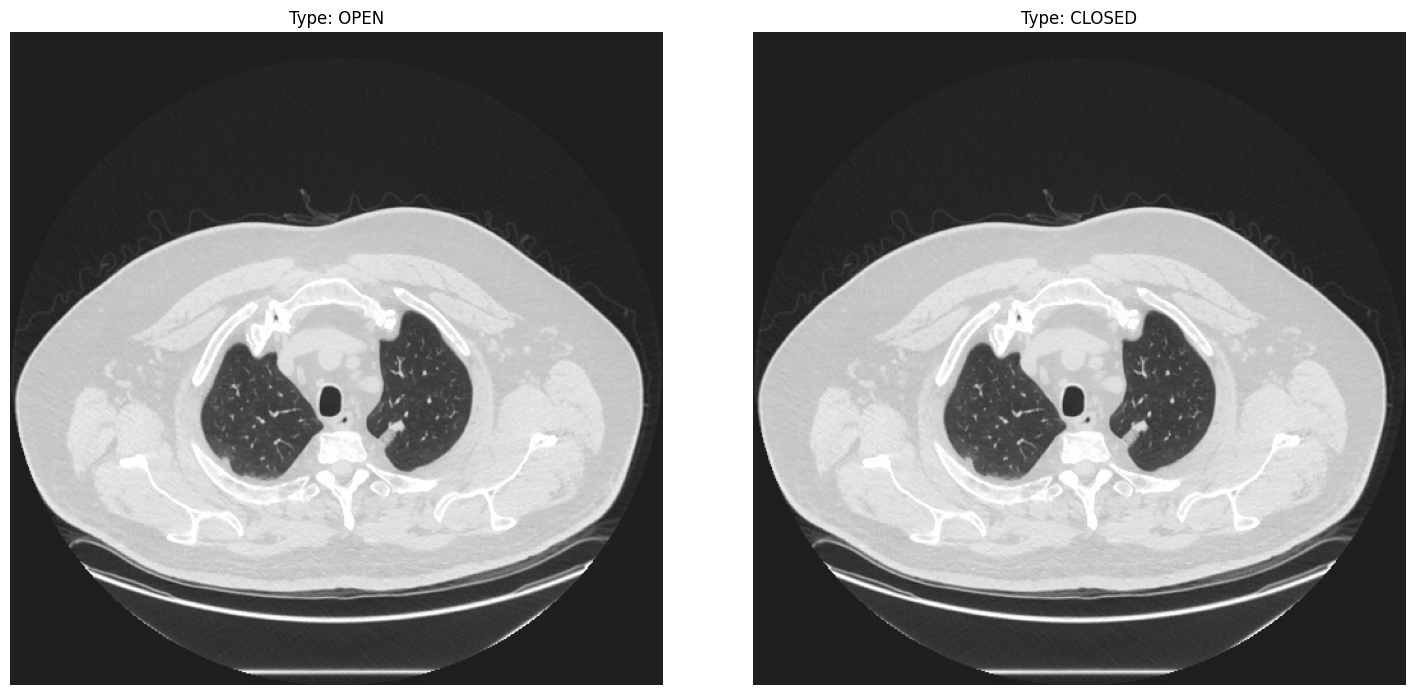


STRATA                         | ACCURACY   | SAMPLES 
------------------------------------------------------------
Mod_CT                         |     0.0847 |      472
Mod_MRI                        |     0.1360 |      228
Mod_X-Ray                      |     0.1690 |      361
Overall                        |     0.1244 |     1061
Type_CLOSED                    |     0.1058 |      416
Type_OPEN                      |     0.1364 |      645
------------------------------------------------------------


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Global BLEU-1:   0.0965
Global ROUGE-L:  0.2381
PubMed-BERTScore:0.8994


In [ ]:
import os, torch, json, numpy as np, evaluate, re
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from transformers import AutoProcessor, LlavaForConditionalGeneration, GenerationConfig
from peft import PeftModel

# 1. A100 HARDWARE ACCELERATION (2026 STANDARDS)
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision('high')
# Enable SDPA for A100 native efficiency without Flash Attention 2
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_mem_efficient_sdp(True) # Memory-efficient fallback
torch.backends.cuda.enable_math_sdp(True)

# 2. SETUP PATHS
DRIVE_ROOT = "/content/drive/MyDrive/LLaVA_Med_Slake_Thesis_2026/slake_dataset"
BASE_MODEL_ID = "llava-hf/llava-1.5-7b-hf"
LORA_PATH = "/content/drive/MyDrive/LLaVA_Med_Slake_Thesis_2026/SOTA_FINAL_LLAVA_2026_now/lora_adapter"
TEST_JSON = "test.json"
CLINICAL_METRIC_BACKBONE = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"

# 3. LOAD MODEL & PROCESSOR (A100 OPTIMIZED)
print(" Loading Model with SDPA (A100 Speed Optimization)...")
processor = AutoProcessor.from_pretrained(BASE_MODEL_ID)
processor.tokenizer.padding_side = "left"

base_model = LlavaForConditionalGeneration.from_pretrained(
    BASE_MODEL_ID,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="sdpa" # Native PyTorch 2.x fast attention
)

print(" Attaching LoRA Adapter...")
model = PeftModel.from_pretrained(base_model, LORA_PATH)
model = model.eval()

# 4. TORCH COMPILE (Saves =20-30% latency on A100)
print(" Compiling model for  high-throughput inference...")
model = torch.compile(model, mode="reduce-overhead")

# 5. DATA LOADING
with open(os.path.join(DRIVE_ROOT, TEST_JSON), 'r') as f:
    test_data = [i for i in json.load(f) if i.get("q_lang") == "en"]

# 6. NLP HELPERS
def clean_medical_text(text):
    text = text.lower().strip()
    text = re.sub(r"^(the image shows|this is a|there is|it looks like|the answer is|it is|shown is)\s*", "", text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

def calculate_f1(pred, label):
    p_t, r_t = pred.split(), label.split()
    common = Counter(p_t) & Counter(r_t)
    num_same = sum(common.values())
    if num_same == 0: return 0
    prec, rec = num_same / len(p_t), num_same / len(r_t)
    return (2 * prec * rec) / (prec + rec)

# 7. HIGH-SPEED INFERENCE ENGINE
BATCH_SIZE = 16 # Increased for A100 40GB/80GB
strat_results = defaultdict(list)
all_preds, all_labels = [], []
samples_to_show = {"OPEN": None, "CLOSED": None}

print(f" Running Fast Inference on {len(test_data)} samples...")

gen_config = GenerationConfig(
    max_new_tokens=25,
    do_sample=False,
    use_cache=True,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
)

for i in tqdm(range(0, len(test_data), BATCH_SIZE)):
    batch = test_data[i : i + BATCH_SIZE]
    imgs = [Image.open(os.path.join(DRIVE_ROOT, "imgs", item['img_name'])).convert("RGB") for item in batch]
    prompts = [f"USER: <image>\n{item['question']}\nASSISTANT:" for item in batch]

    inputs = processor(text=prompts, images=imgs, return_tensors="pt", padding=True).to("cuda", torch.bfloat16)

    with torch.inference_mode():
        output_ids = model.generate(**inputs, generation_config=gen_config)

    decoded_texts = processor.batch_decode(output_ids, skip_special_tokens=True)

    for idx, full_text in enumerate(decoded_texts):
        raw_pred = full_text.split("ASSISTANT:")[-1]
        prediction = clean_medical_text(raw_pred)
        label = clean_medical_text(str(batch[idx]['answer']))

        item_meta = batch[idx]
        f1 = calculate_f1(prediction, label)
        is_correct = 1 if (item_meta['answer_type'] == "CLOSED" and prediction == label) or \
                          (item_meta['answer_type'] != "CLOSED" and f1 >= 0.5) else 0

        if samples_to_show[item_meta['answer_type']] is None:
            samples_to_show[item_meta['answer_type']] = {
                "img": imgs[idx], "q": item_meta['question'],
                "p": raw_pred.strip(), "gt": batch[idx]['answer']
            }

        strata = ["Overall", f"Type_{item_meta['answer_type']}", f"Mod_{item_meta.get('modality', 'unknown')}"]
        for s in strata:
            strat_results[s].append(is_correct)
        all_preds.append(prediction)
        all_labels.append(label)

# 8. VISUALIZE SAMPLES (OPEN & CLOSED)
print("\nDisplaying Qualitative Samples...")
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
for ax, (atype, data) in zip(axes, samples_to_show.items()):
    if data:
        ax.imshow(data['img'])
        ax.set_title(f"Type: {atype}")
        ax.axis('off')
        print(f"\n[{atype} Sample]\nQ: {data['q']}\nP: {data['p']}\nGT: {data['gt']}")
plt.tight_layout()
plt.show()

# 9. FINAL METRICS
print("\n" + "="*60)
print(f"{'STRATA':<30} | {'ACCURACY':<10} | {'SAMPLES':<8}")
print("-" * 60)
for s, scores in sorted(strat_results.items()):
    print(f"{s:<30} | {np.mean(scores):>10.4f} | {len(scores):>8}")

print("-" * 60)
# Use clinical BERTScore for thesis validity
bleu_m, rouge_m, bert_m = evaluate.load("bleu"), evaluate.load("rouge"), evaluate.load("bertscore")
b1 = bleu_m.compute(predictions=all_preds, references=[[l] for l in all_labels], max_order=1)
rl = rouge_m.compute(predictions=all_preds, references=all_labels)['rougeL']
bs = bert_m.compute(predictions=all_preds, references=all_labels, model_type=CLINICAL_METRIC_BACKBONE, num_layers=12)

print(f"Global BLEU-1:   {b1['bleu']:.4f}")
print(f"Global ROUGE-L:  {rl:.4f}")
print(f"PubMed-BERTScore:{np.mean(bs['f1']):.4f}")
print("="*60)


📸 Displaying stratified samples with linked images...


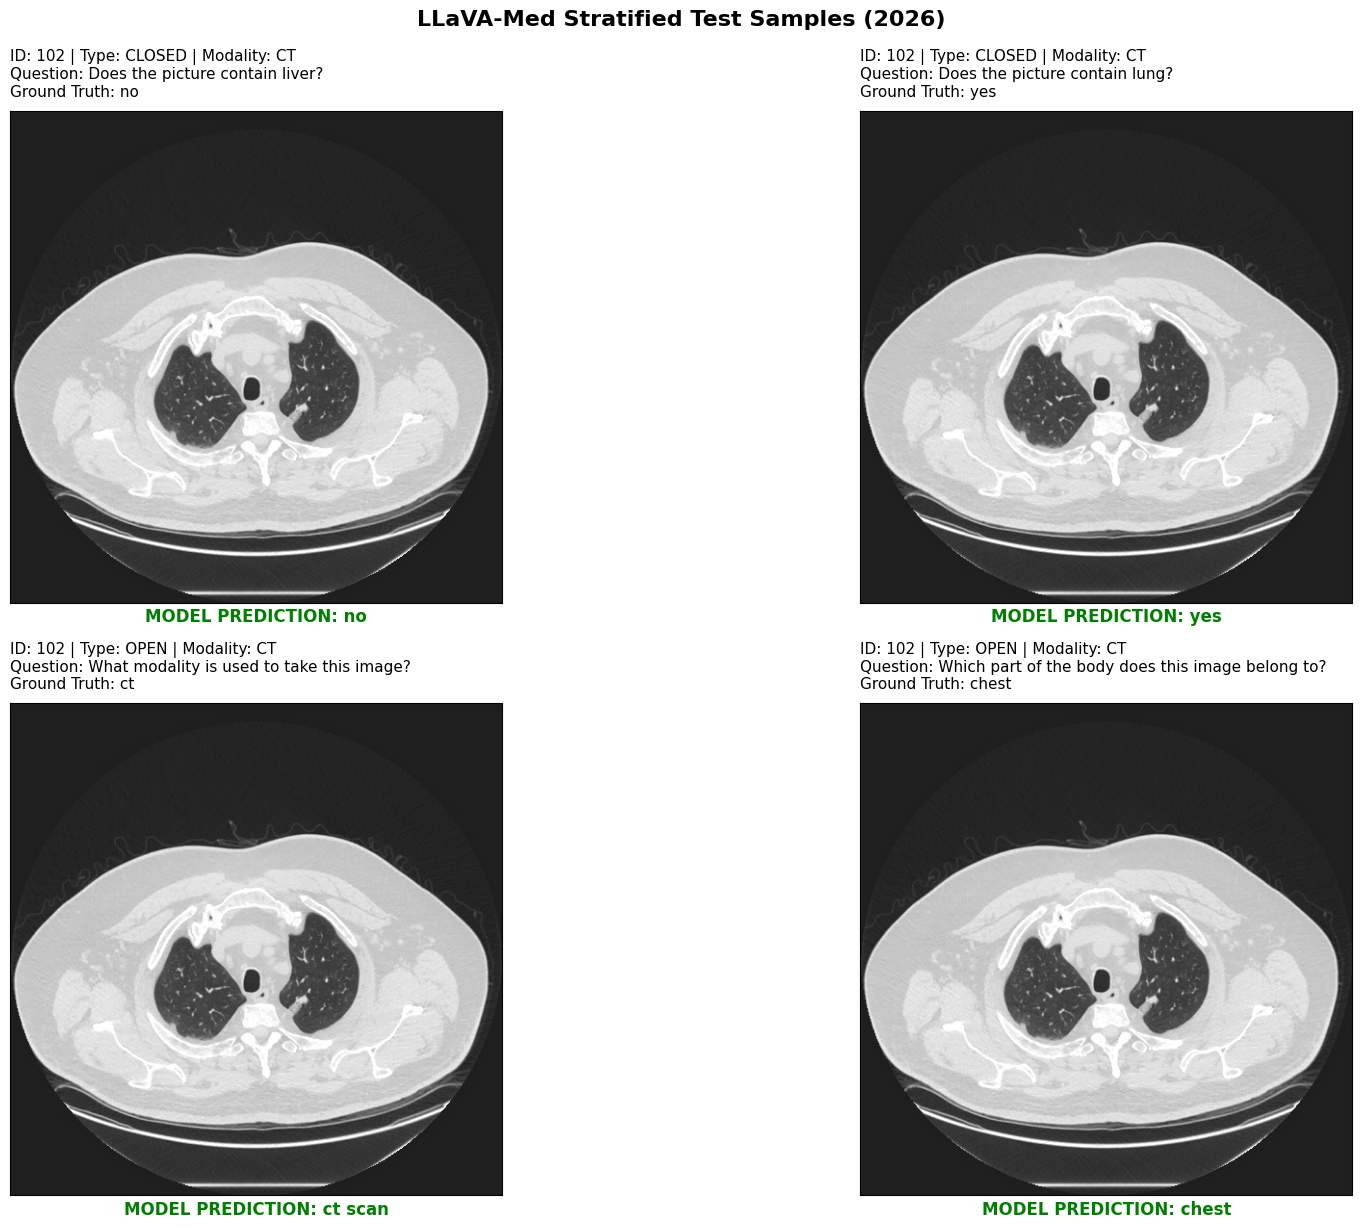

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

def display_stratified_samples(test_data, all_preds, all_labels, num_samples=2):
    """
    Finds and displays the specific images associated with CLOSED and OPEN questions.
    """
    # 1. Identify indices for both types
    closed_idxs = [i for i, item in enumerate(test_data) if item['answer_type'] == "CLOSED"]
    open_idxs = [i for i, item in enumerate(test_data) if item['answer_type'] == "OPEN"]

    # 2. Select samples (e.g., the first 2 of each)
    display_idxs = closed_idxs[:num_samples] + open_idxs[:num_samples]

    plt.figure(figsize=(20, 12))

    for i, idx in enumerate(display_idxs):
        item = test_data[idx]
        pred = all_preds[idx]
        label = all_labels[idx]

        # 3. Load the specific image belonging to THIS question
        # Assuming DRIVE_ROOT and the "imgs" folder structure from your training code
        img_path = os.path.join(DRIVE_ROOT, "imgs", item['img_name'])

        try:
            raw_image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            # Fallback if your folder structure is imgs/imgs/
            img_path = os.path.join(DRIVE_ROOT, "imgs", "imgs", item['img_name'])
            raw_image = Image.open(img_path).convert("RGB")

        # 4. Determine correctness for color coding
        # Using your calculate_f1 function for OPEN and exact match for CLOSED
        f1_val = calculate_f1(pred, label)
        is_correct = (item['answer_type'] == "CLOSED" and pred == label) or \
                     (item['answer_type'] == "OPEN" and f1_val >= 0.5)

        color = 'green' if is_correct else 'red'

        # 5. Plotting
        plt.subplot(2, 2, i + 1)
        plt.imshow(raw_image)

        # Build the descriptive title
        title_text = (
            f"ID: {item.get('img_id', 'N/A')} | Type: {item['answer_type']} | Modality: {item.get('modality', 'unknown')}\n"
            f"Question: {item['question']}\n"
            f"Ground Truth: {label}"
        )

        plt.title(title_text, fontsize=11, loc='left', pad=10)
        plt.xlabel(f"MODEL PREDICTION: {pred}", fontsize=12, fontweight='bold', color=color)
        plt.xticks([]); plt.yticks([])

    plt.tight_layout()
    plt.suptitle("LLaVA-Med Stratified Test Samples (2026)", fontsize=16, fontweight='bold', y=1.02)
    plt.show()

# Execution
if __name__ == "__main__":
    # Ensure test_data, all_preds, and all_labels from your inference cell are in memory
    print("📸 Displaying stratified samples with linked images...")
    display_stratified_samples(test_data, all_preds, all_labels)
